In [1]:
# === Library ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score
)

from imblearn.over_sampling import SMOTE

# === Load Dataset ===
DATA_PATH = '/content/application_train.csv'
df = pd.read_csv(DATA_PATH)

# Preview dataset
print(f"Dataset shape: {df.shape}")
display(df.head())

Dataset shape: (114502, 122)


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...               0.0              0.0              0.0              0.0   
1  ...               0.0              0.0              0.0              0.0   
2  ...               0.0              0.0              0.0              0.0   
3  ...               0.0              0.0              0.0              0.0   
4  ...               0.0              0.0              0.0              0.0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

Data Understanding

In [2]:
def summarize(df):
    print(df.shape)                    # (rows, cols)
    display(df.dtypes)
    display(df.columns)
    df.info()
    display(df.describe(include='all'))

summarize(df)

(114502, 122)


SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
Length: 122, dtype: object

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114502 entries, 0 to 114501
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(92), int64(14), object(16)
memory usage: 106.6+ MB


SK_ID_CURR         TARGET NAME_CONTRACT_TYPE CODE_GENDER  \
count   114502.000000  114502.000000             114502      114502   
unique            NaN            NaN                  2           3   
top               NaN            NaN         Cash loans           F   
freq              NaN            NaN             103628       75379   
mean    166420.252354       0.081457                NaN         NaN   
std      38342.443991       0.273537                NaN         NaN   
min     100002.000000       0.000000                NaN         NaN   
25%     133266.250000       0.000000                NaN         NaN   
50%     166357.500000       0.000000                NaN         NaN   
75%     199646.750000       0.000000                NaN         NaN   
max     232775.000000       1.000000                NaN         NaN   

       FLAG_OWN_CAR FLAG_OWN_REALTY   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count        114502          114502  114502.000000      1.145020e+05   
unique            2               2            NaN               NaN   
top               N               Y            NaN               NaN   
freq          75671           79430            NaN               NaN   
mean            NaN             NaN       0.417844      1.692890e+05   
std             NaN             NaN       0.721535      3.604442e+05   
min             NaN             NaN       0.000000      2.565000e+04   
25%             NaN             NaN       0.000000      1.125000e+05   
50%             NaN             NaN       0.000000      1.440000e+05   
75%             NaN             NaN       1.000000      2.025000e+05   
max             NaN             NaN      12.000000      1.170000e+08   

          AMT_CREDIT    AMT_ANNUITY  ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19  \
count   1.145020e+05  114495.000000  ...     114501.000000    114501.000000   
unique           NaN            NaN  ...               NaN              NaN   
top              NaN            NaN  ...               NaN              NaN   
freq             NaN            NaN  ...               NaN              NaN   
mean    5.987835e+05   27087.874453  ...          0.008271         0.000629   
std     4.021026e+05   14530.615408  ...          0.090567         0.025068   
min     4.500000e+04    1980.000000  ...          0.000000         0.000000   
25%     2.700000e+05   16465.500000  ...          0.000000         0.000000   
50%     5.124465e+05   24880.500000  ...          0.000000         0.000000   
75%     8.086500e+05   34596.000000  ...          0.000000         0.000000   
max     4.050000e+06  258025.500000  ...          1.000000         1.000000   

       FLAG_DOCUMENT_20 FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR  \
count     114501.000000    114501.000000               99115.000000   
unique              NaN              NaN                        NaN   
top                 NaN              NaN                        NaN   
freq                NaN              NaN                        NaN   
mean           0.000533         0.000306                   0.006649   
std            0.023075         0.017481                   0.086209   
min            0.000000         0.000000                   0.000000   
25%            0.000000         0.000000                   0.000000   
50%            0.000000         0.000000                   0.000000   
75%            0.000000         0.000000                   0.000000   
max            1.000000         1.000000                   3.000000   

       AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_WEEK  \
count               99115.000000                99115.000000   
unique                       NaN                         NaN   
top                          NaN                         NaN   
freq                         NaN                         NaN   
mean                    0.007153                    0.033728   
std                     0.108646                    0.203344   
min                     0.000000           

In [3]:
# === Missing values (rapi, tetap hasil sama) ===
na_count = df.isna().sum()
na_pct   = (na_count / len(df) * 100).round(2)

missing_df = (
    pd.DataFrame({
        'Missing Data': na_count,
        'Percentage': na_pct
    })
    .sort_values(by='Percentage', ascending=False)
)

# format ke string dengan '%' di akhir (nilai sudah disort dari angka)
missing_df['Percentage'] = missing_df['Percentage'].astype(str) + '%'

missing_df  # sama: DataFrame dengan 2 kolom seperti sebelumnya


Missing Data Percentage
COMMONAREA_AVG                   79929     69.81%
COMMONAREA_MODE                  79929     69.81%
COMMONAREA_MEDI                  79929     69.81%
NONLIVINGAPARTMENTS_MEDI         79406     69.35%
NONLIVINGAPARTMENTS_MODE         79406     69.35%
...                                ...        ...
FLAG_DOCUMENT_16                     1       0.0%
FLAG_DOCUMENT_15                     1       0.0%
FLAG_DOCUMENT_14                     1       0.0%
FLAG_DOCUMENT_20                     1       0.0%
FLAG_DOCUMENT_21                     1       0.0%

[122 rows x 2 columns]

/tmp/ipython-input-1187295603.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


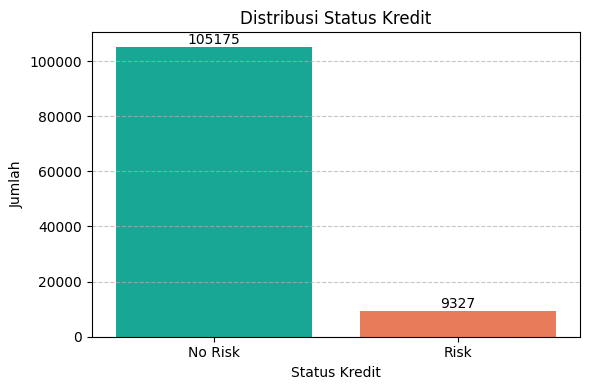

TARGET
0    105175
1      9327
Name: count, dtype: int64


In [5]:
# === Distribusi TARGET: Bar Chart ===
target_counts = df['TARGET'].value_counts()

plt.figure(figsize=(6, 4))
sns.barplot(
    x=target_counts.index,
    y=target_counts.values,
    palette=['#00bfa5', '#ff7043']  # warna baru: teal & orange
)

plt.xticks([0, 1], ['No Risk', 'Risk'])
plt.ylabel('Jumlah')
plt.xlabel('Status Kredit')
plt.title('Distribusi Status Kredit')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, count in enumerate(target_counts.values):
    plt.text(i, count + (0.01 * max(target_counts.values)), str(count), ha='center')

plt.tight_layout()
plt.show()

print(target_counts)


In [6]:
# === 1) Kolom object & ringkasan unik (hasil sama) ===
object_cols = df.select_dtypes(include='object').columns
object_cols

# catatan: baris di bawah ini memang menghitung jumlah kolom object unik
# (bukan jumlah nilai unik per kolom) — dipertahankan agar hasil sama
unique_counts = object_cols.nunique()
unique_counts

# === 2) Low-variance & high-cardinality (hasil sama) ===
low_variance_cols = [col for col in df.columns if df[col].nunique() == 1]
print("Kolom dengan hanya 1 nilai unik (tidak informatif):")
print(low_variance_cols)

high_card_cols = [col for col in object_cols if df[col].nunique() > 10]
print("Kolom dengan lebih dari 10 nilai unik (high cardinality):")
print(high_card_cols)

# === 3) Jumlah kolom yang punya missing (hasil sama) ===
jumlah_missing = df.isnull().any().sum()
print(jumlah_missing)

# === 4) Drop kolom dengan >50% null (hasil sama, tanpa inplace di luar fungsi) ===
def drop_columns(df_):
    missing_pct = df_.isnull().mean() * 100
    cols_to_drop = missing_pct[missing_pct > 50].index
    return df_.drop(columns=cols_to_drop)

df = drop_columns(df)
df.isnull().any().sum()

# === 5) Imputasi missing (hasil sama) ===
def input_missing_value(df_):
    df_ = df_.copy()
    cols_with_na = df_.columns[df_.isnull().any()]
    for col in cols_with_na:
        if df_[col].dtype == 'object':
            df_[col] = df_[col].fillna(df_[col].mode()[0])
        else:
            df_[col] = df_[col].fillna(df_[col].median())
    return df_

df = input_missing_value(df)


Kolom dengan hanya 1 nilai unik (tidak informatif):
[]
Kolom dengan lebih dari 10 nilai unik (high cardinality):
['OCCUPATION_TYPE', 'ORGANIZATION_TYPE']
96


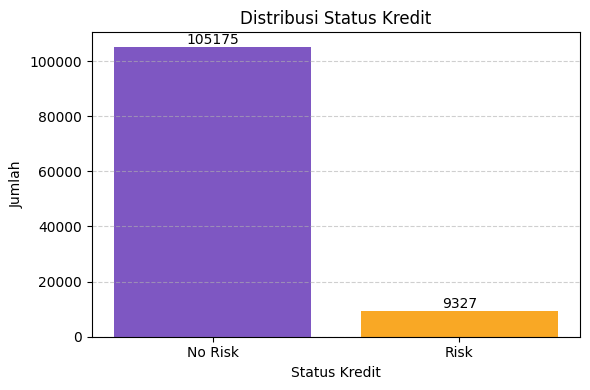

TARGET
0    105175
1      9327
Name: count, dtype: int64


In [7]:
# Distribusi TARGET — bar chart dengan palet baru (ungu & emas)
target_counts = df['TARGET'].value_counts()

plt.figure(figsize=(6, 4))
plt.bar([0, 1], target_counts.values, tick_label=['No Risk', 'Risk'], color=['#7e57c2', '#f9a825'])
plt.ylabel('Jumlah')
plt.xlabel('Status Kredit')
plt.title('Distribusi Status Kredit')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Tampilkan angka di atas batang
for i, v in enumerate(target_counts.values):
    plt.text(i, v + 0.01 * target_counts.values.max(), str(v), ha='center')

plt.tight_layout()
plt.show()

print(target_counts)


In [9]:
# === Ringkasan missing & duplikat (hasil sama) ===
df.isnull().any().sum()

df.duplicated().sum()


np.int64(0)

In [10]:
# === Kolom object yang mengandung 'XNA' atau 'Unknown' (hasil sama) ===
obj = df.select_dtypes(include='object')

columns_with_xna_or_unknown = (
    obj.isin({'XNA', 'Unknown'}).any()
    .pipe(lambda s: s[s].index.tolist())
)

print("Kolom yang mengandung 'XNA' atau 'Unknown':")
print(columns_with_xna_or_unknown)


Kolom yang mengandung 'XNA' atau 'Unknown':
['CODE_GENDER', 'NAME_FAMILY_STATUS', 'ORGANIZATION_TYPE']


In [11]:
# === Distribusi kategori (hasil sama) ===
df['CODE_GENDER'].value_counts()
df['NAME_FAMILY_STATUS'].value_counts()
df['ORGANIZATION_TYPE'].value_counts()


ORGANIZATION_TYPE
Business Entity Type 3    25445
XNA                       20540
Self-employed             14177
Other                      6252
Medicine                   4181
Business Entity Type 2     3979
Government                 3888
School                     3312
Trade: type 7              2827
Kindergarten               2565
Construction               2399
Business Entity Type 1     2233
Transport: type 4          1985
Industry: type 3           1257
Trade: type 3              1247
Industry: type 9           1239
Security                   1228
Housing                    1107
Industry: type 11          1063
Military                    997
Bank                        987
Agriculture                 879
Postal                      838
Police                      829
Transport: type 2           817
Security Ministries         772
Trade: type 2               712
Restaurant                  668
Services                    628
Industry: type 7            495
University                  484
Transport: type 3           430
Industry: type 1            393
Hotel                       367
Electricity                 339
Industry: type 4            333
Trade: type 6               236
Industry: type 5            231
Telecom                     215
Insurance                   214
Emergency                   207
Industry: type 2            175
Trade: type 1               155
Advertising                 155
Culture                     149
Realtor                     139
Industry: type 12           128
Mobile                      126
Legal Services              116
Cleaning                     99
Transport: type 1            80
Industry: type 6             40
Industry: type 10            36
Religion                     30
Industry: type 13            26
Trade: type 4                20
Trade: type 5                17
Industry: type 8             16
Name: count, dtype: int64

In [12]:
# === Replace nilai spesifik dengan modus kolom (hasil sama) ===
df['CODE_GENDER'] = df['CODE_GENDER'].replace(
    {'XNA': df['CODE_GENDER'].mode(dropna=True).iat[0]}
)
df['NAME_FAMILY_STATUS'] = df['NAME_FAMILY_STATUS'].replace(
    {'Unknown': df['NAME_FAMILY_STATUS'].mode(dropna=True).iat[0]}
)


In [13]:
# === Cek ulang kolom yang masih mengandung 'XNA'/'Unknown' (hasil sama) ===
obj = df.select_dtypes(include='object')
columns_with_xna_or_unknown = (
    obj.isin({'XNA', 'Unknown'}).any()
    .pipe(lambda s: s[s].index.tolist())
)

print("Kolom yang mengandung 'XNA' atau 'Unknown':")
print(columns_with_xna_or_unknown)


Kolom yang mengandung 'XNA' atau 'Unknown':
['ORGANIZATION_TYPE']


In [14]:
# === Drop kolom high-cardinality & kolom tertentu (hasil sama) ===
df = df.drop(columns=high_card_cols, errors='ignore')
df = df.drop(columns=['SK_ID_CURR'], errors='ignore')

# Drop semua kolom yang mengandung substring 'FLAG_DOCUMENT' (hasil sama)
flag_document_cols = df.filter(like='FLAG_DOCUMENT').columns
df = df.drop(columns=flag_document_cols)

df.head()


TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0       1         Cash loans           M            N               Y   
1       0         Cash loans           F            N               N   
2       0    Revolving loans           M            Y               Y   
3       0         Cash loans           F            N               Y   
4       0         Cash loans           M            N               Y   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   
2             0           67500.0    135000.0       6750.0         135000.0   
3             0          135000.0    312682.5      29686.5         297000.0   
4             0          121500.0    513000.0      21865.5         513000.0   

   ... DEF_30_CNT_SOCIAL_CIRCLE OBS_60_CNT_SOCIAL_CIRCLE  \
0  ...                      2.0                      2.0   
1  ...                      0.0                      1.0   
2  ...                      0.0                      0.0   
3  ...                      0.0                      2.0   
4  ...                      0.0                      0.0   

  DEF_60_CNT_SOCIAL_CIRCLE DAYS_LAST_PHONE_CHANGE AMT_REQ_CREDIT_BUREAU_HOUR  \
0                      2.0                -1134.0                        0.0   
1                      0.0                 -828.0                        0.0   
2                      0.0                 -815.0                        0.0   
3                      0.0                 -617.0                        0.0   
4                      0.0                -1106.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_WEEK  \
0                        0.0                         0.0   
1                        0.0                         0.0   
2                        0.0                         0.0   
3                        0.0                         0.0   
4                        0.0                         0.0   

   AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_QRT  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_YEAR  
0                         1.0  
1                         0.0  
2                         0.0  
3                         1.0  
4                         0.0  

[5 rows x 58 columns]

/tmp/ipython-input-2740577328.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


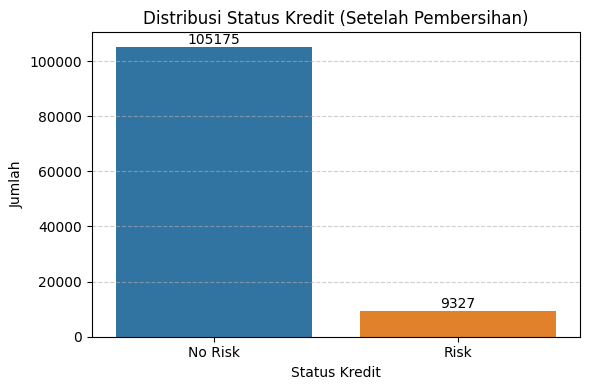

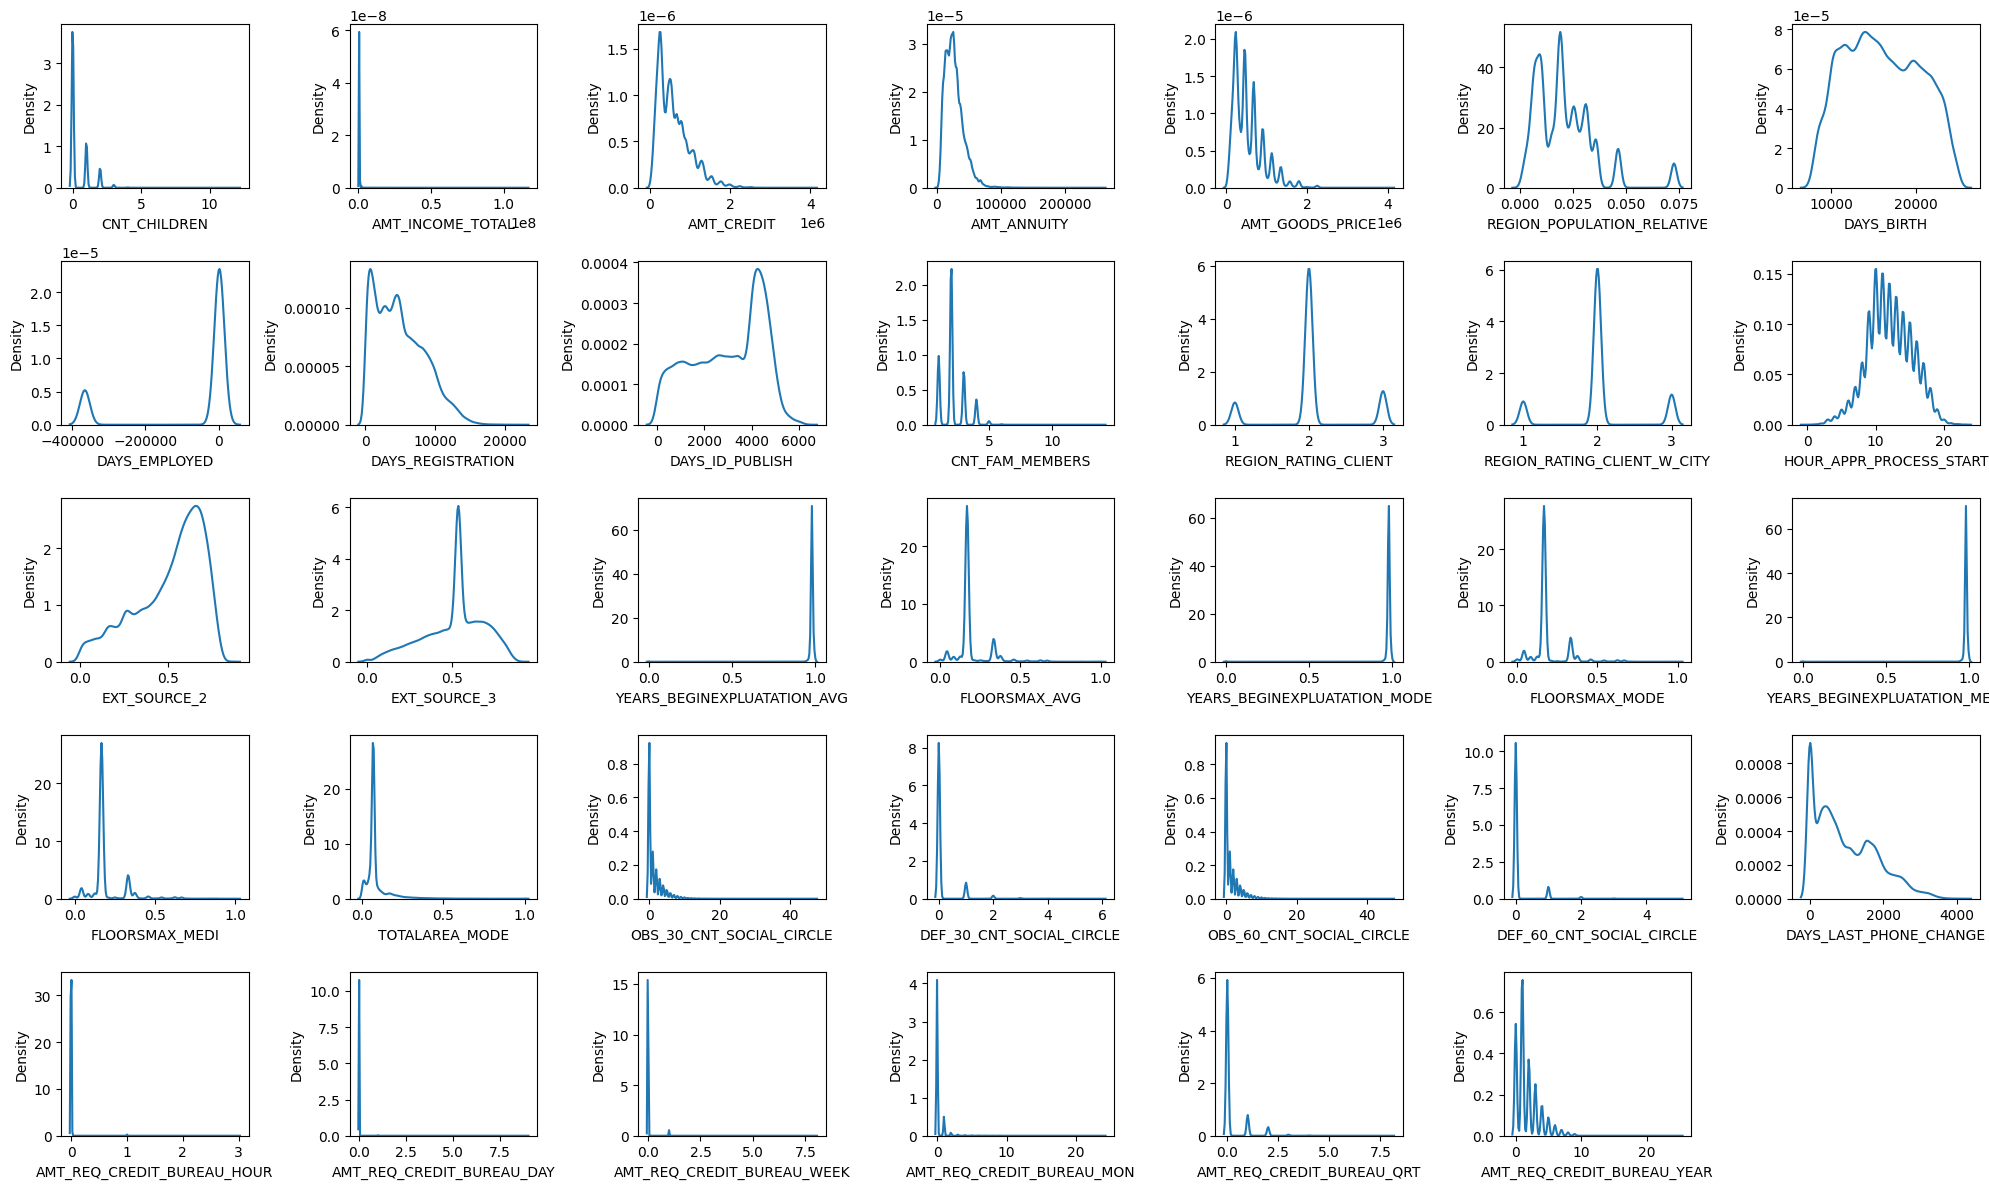

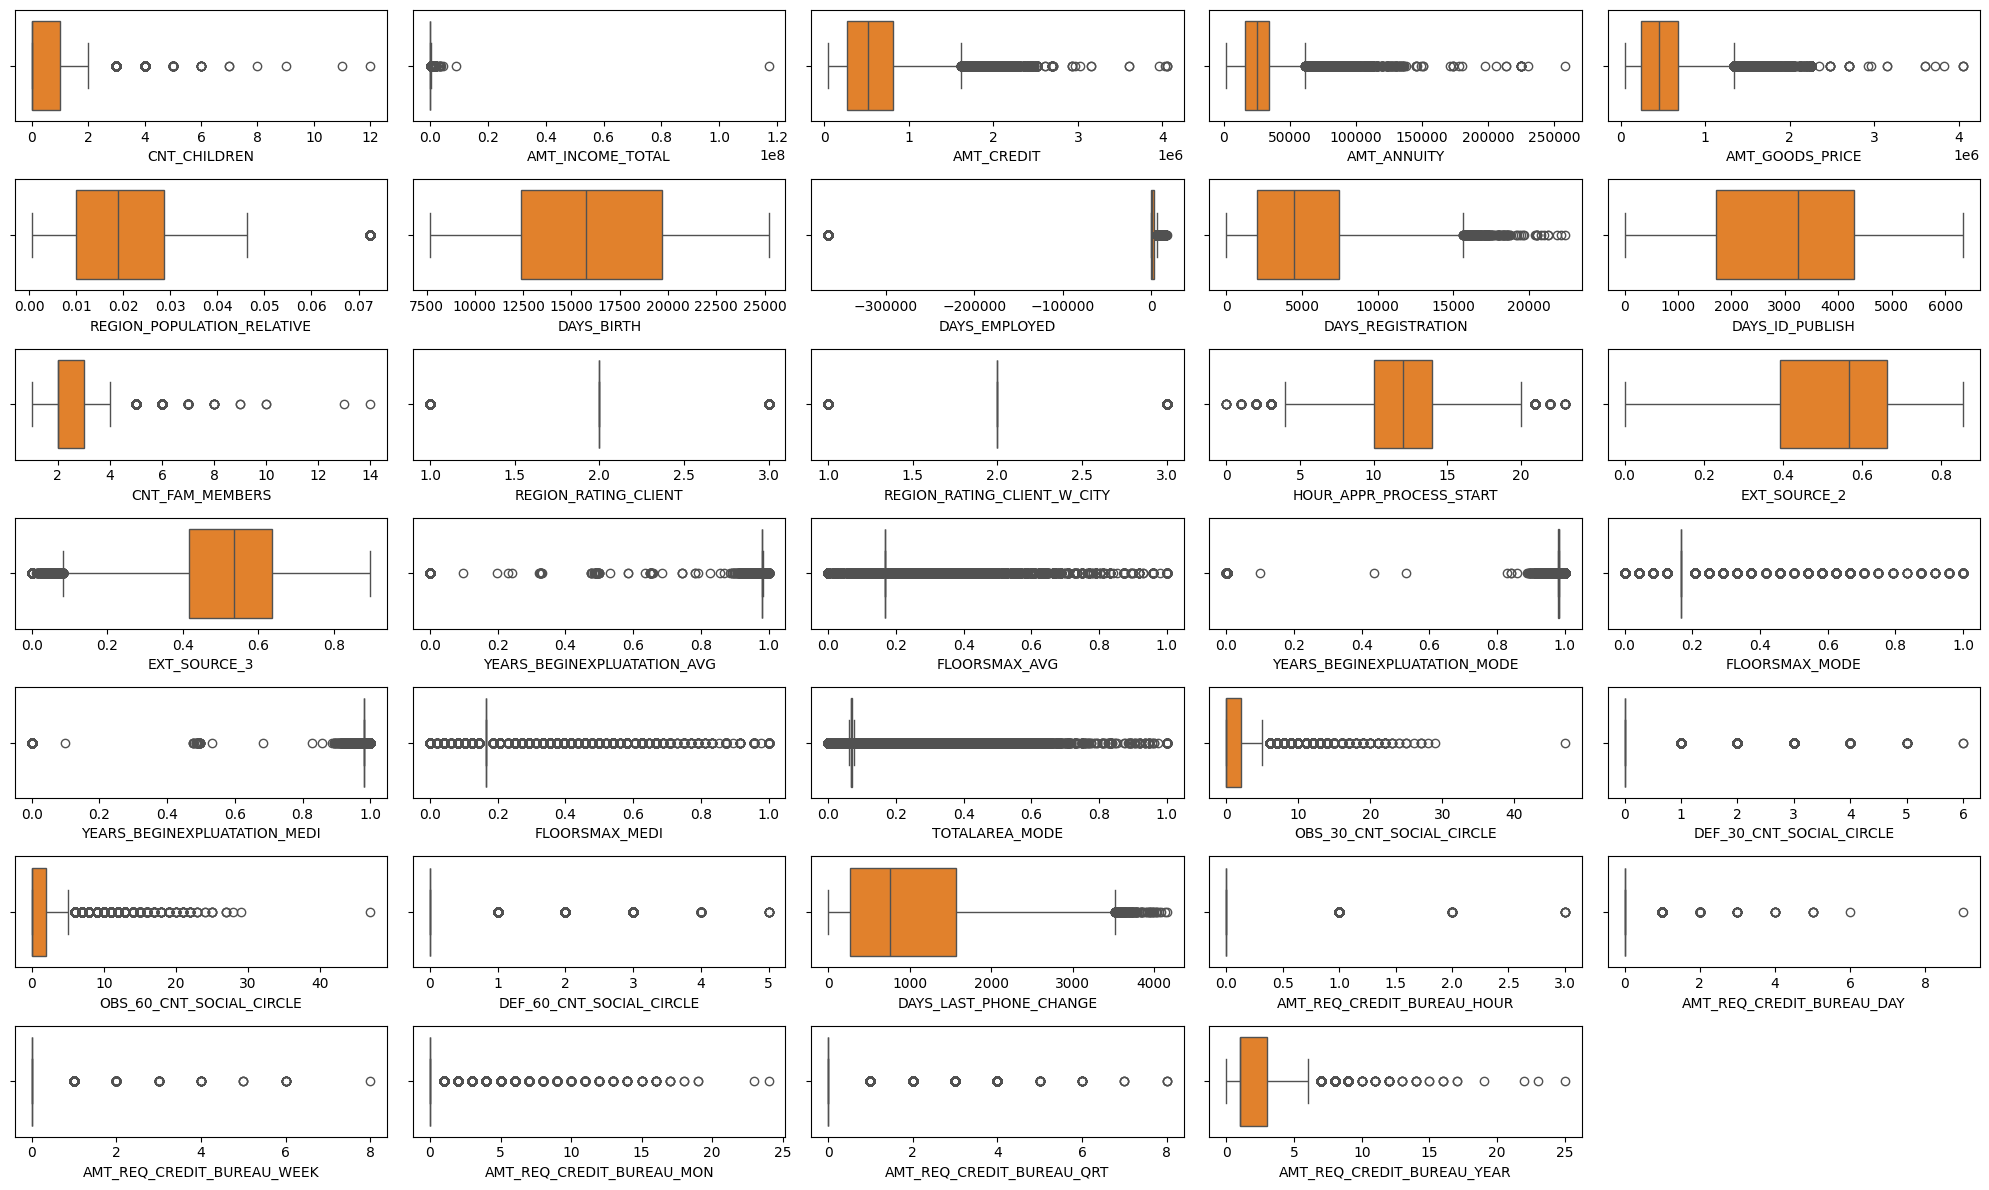

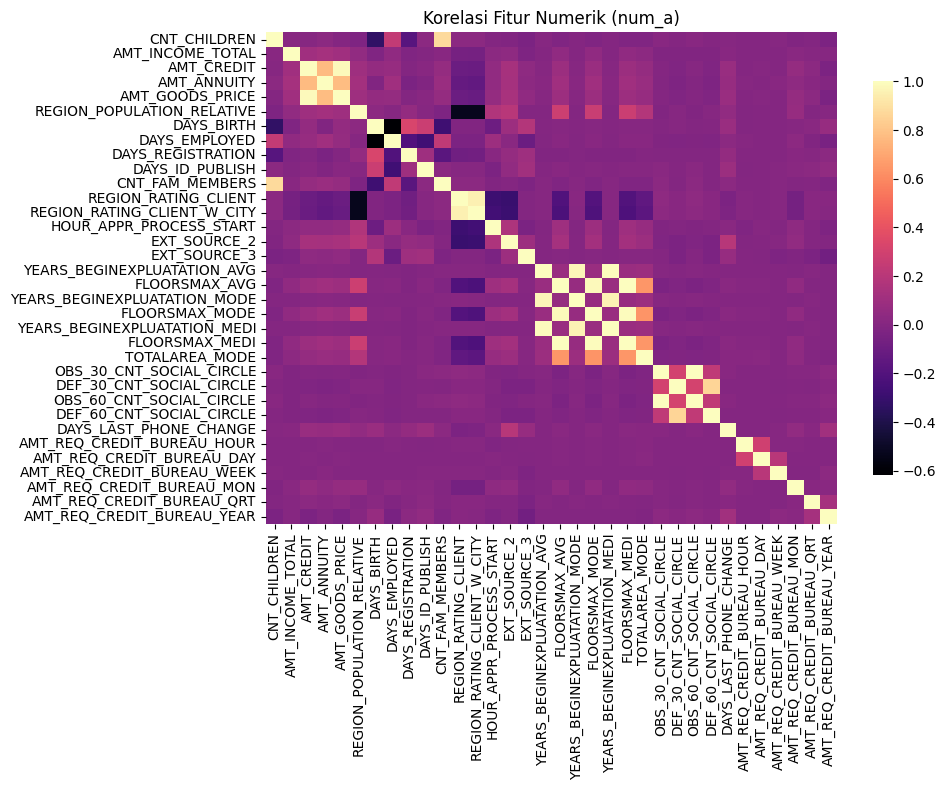

/tmp/ipython-input-4006814578.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=num[column], palette=['#2ca02c', '#d62728'])  # hijau & merah
/tmp/ipython-input-4006814578.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=num[column], palette=['#2ca02c', '#d62728'])  # hijau & merah
/tmp/ipython-input-4006814578.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=num[column], palette=['#2ca02c', '#d62728'])  # hijau & merah
/tmp/ipython-input-4006814578.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is d

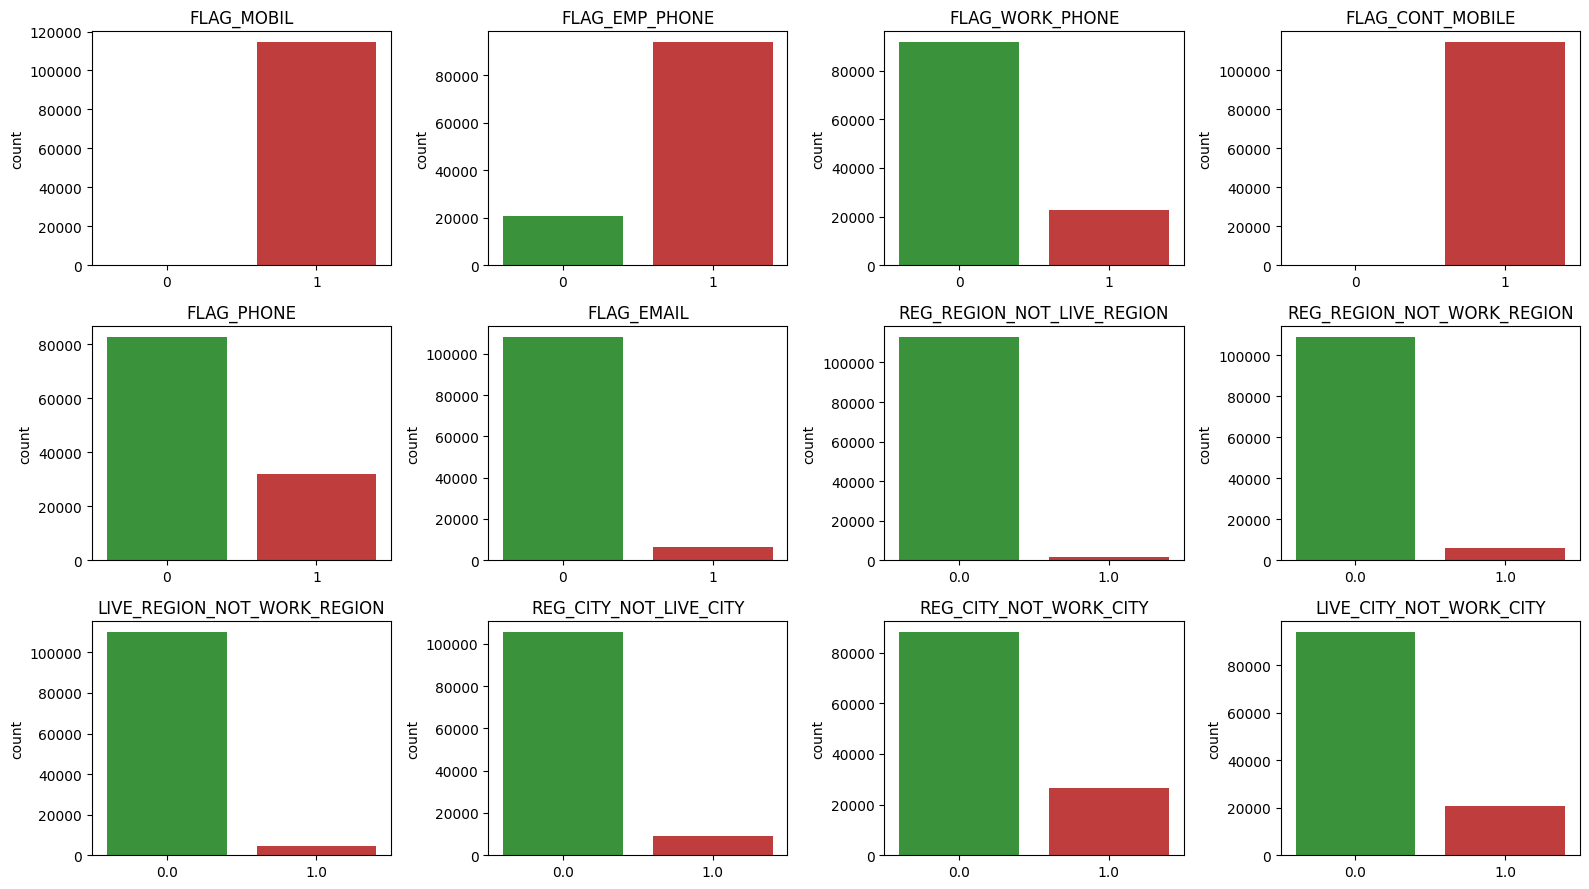

CNT_CHILDREN  AMT_INCOME_TOTAL    AMT_CREDIT    AMT_ANNUITY  \
count  114502.000000      1.145020e+05  1.145020e+05  114502.000000   
mean        0.417844      1.692890e+05  5.987835e+05   27087.739507   
std         0.721535      3.604442e+05  4.021026e+05   14530.181488   
min         0.000000      2.565000e+04  4.500000e+04    1980.000000   
25%         0.000000      1.125000e+05  2.700000e+05   16465.500000   
50%         0.000000      1.440000e+05  5.124465e+05   24880.500000   
75%         1.000000      2.025000e+05  8.086500e+05   34596.000000   
max        12.000000      1.170000e+08  4.050000e+06  258025.500000   

       AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE     DAYS_BIRTH  \
count     1.145020e+05               114502.000000  114502.000000   
mean      5.380731e+05                    0.020856   16031.931329   
std       3.693273e+05                    0.013817    4367.940590   
min       4.500000e+04                    0.000533    7676.000000   
25%       2.385000e+05                    0.010006   12394.000000   
50%       4.500000e+05                    0.018850   15744.000000   
75%       6.795000e+05                    0.028663   19677.000000   
max       4.050000e+06                    0.072508   25201.000000   

       DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  ...  \
count  114502.000000      114502.000000    114502.000000  ...   
mean   -63564.474952        4982.431206      2992.846073  ...   
std    141065.049775        3523.967777      1510.108437  ...   
min   -365243.000000          -0.000000         0.000000  ...   
25%       289.000000        2009.250000      1715.000000  ...   
50%      1216.000000        4490.000000      3254.000000  ...   
75%      2757.000000        7470.000000      4297.000000  ...   
max     17531.000000       22392.000000      6337.000000  ...   

       DEF_30_CNT_SOCIAL_CIRCLE  OBS_60_CNT_SOCIAL_CIRCLE  \
count             114502.000000             114502.000000   
mean                   0.142085                  1.400316   
std                    0.439623                  2.290723   
min                    0.000000                  0.000000   
25%                    0.000000                  0.000000   
50%                    0.000000                  0.000000   
75%                    0.000000                  2.000000   
max                    6.000000                 47.000000   

       DEF_60_CNT_SOCIAL_CIRCLE  DAYS_LAST_PHONE_CHANGE  \
count             114502.000000           114502.000000   
mean                   0.098601              962.803287   
std                    0.356066              827.516084   
min                    0.000000               -0.000000   
25%                    0.000000              272.000000   
50%                    0.000000              756.000000   
75%                    0.000000             1570.000000   
max                    5.000000             4153.000000   

       AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
count               114502.000000              114502.000000   
mean                     0.005755                   0.006192   
std                      0.080240                   0.101112   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   0.000000   
75%                      0.000000                   0.000000   
max                      3.000000                   9.000000   

       AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
count               114502.000000              114502.000000   
mean                     0.029196                   0.231000   
std                      0.189538                   0.858522   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   0.000000   
75%                      0.000000                   0

In [17]:
# === 1) Pisah fitur & pilih numerik (hasil sama) ===
x = df.drop(columns='TARGET')
num = x.select_dtypes(exclude='object').copy()

# === 2) Balik kolom yang punya nilai negatif (hasil sama) ===
negative_columns = num.columns[(num < 0).any()].tolist()
num[negative_columns] = -num[negative_columns]   # sama dengan * -1

# === 3) Bagi kolom numerik: num_a (>2 unik) & num_b (≤2 unik) (hasil sama) ===
df_num = num.nunique().rename('Total_unique').reset_index().rename(
    columns={'index': 'Name_of_column'}
)
num_a, num_b = [], []
for i, col in enumerate(df_num['Name_of_column']):
    if df_num['Total_unique'][i] > 2:
        num_a.append(col)
    else:
        num_b.append(col)

# === 4) KDE untuk num_a (warna beda) — tetap dua figure seperti kode awal ===
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 12))
for i, column in enumerate(num[num_a].columns, 1):
    plt.subplot(5, 7, i)
    sns.kdeplot(data=num, x=column, bw_adjust=1.0, fill=False, color='#1f77b4')  # biru
    plt.xlabel(column)
    plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 12))
for i, column in enumerate(num[num_a].columns, 1):
    plt.subplot(7, 5, i)
    sns.boxplot(data=num, x=column, color='#ff7f0e')  # oranye
    plt.xlabel(column)
    plt.tight_layout()
plt.show()

# === 5) VISUALISASI TAMBAHAN: Heatmap korelasi num_a (warna berbeda) ===
if len(num_a) > 1:  # butuh ≥2 kolom untuk korelasi
    corr = num[num_a].corr(numeric_only=True)
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, cmap='magma', annot=False, square=False,
                cbar_kws={'shrink': .8})
    plt.title('Korelasi Fitur Numerik (num_a)')
    plt.tight_layout()
    plt.show()

# === 6) VISUALISASI TAMBAHAN: Countplot untuk num_b (bila ada) ===
# fitur dengan ≤2 nilai unik lebih cocok bar chart ketimbang KDE/boxplot
if len(num_b) > 0:
    ncols = 4
    nrows = (len(num_b) + ncols - 1) // ncols
    plt.figure(figsize=(4*ncols, 3*nrows))
    for i, column in enumerate(num_b, 1):
        plt.subplot(nrows, ncols, i)
        sns.countplot(x=num[column], palette=['#2ca02c', '#d62728'])  # hijau & merah
        plt.title(column)
        plt.xlabel('')
        plt.tight_layout()
    plt.show()

# === 7) Ringkasan statistik (hasil sama) ===
num.describe()


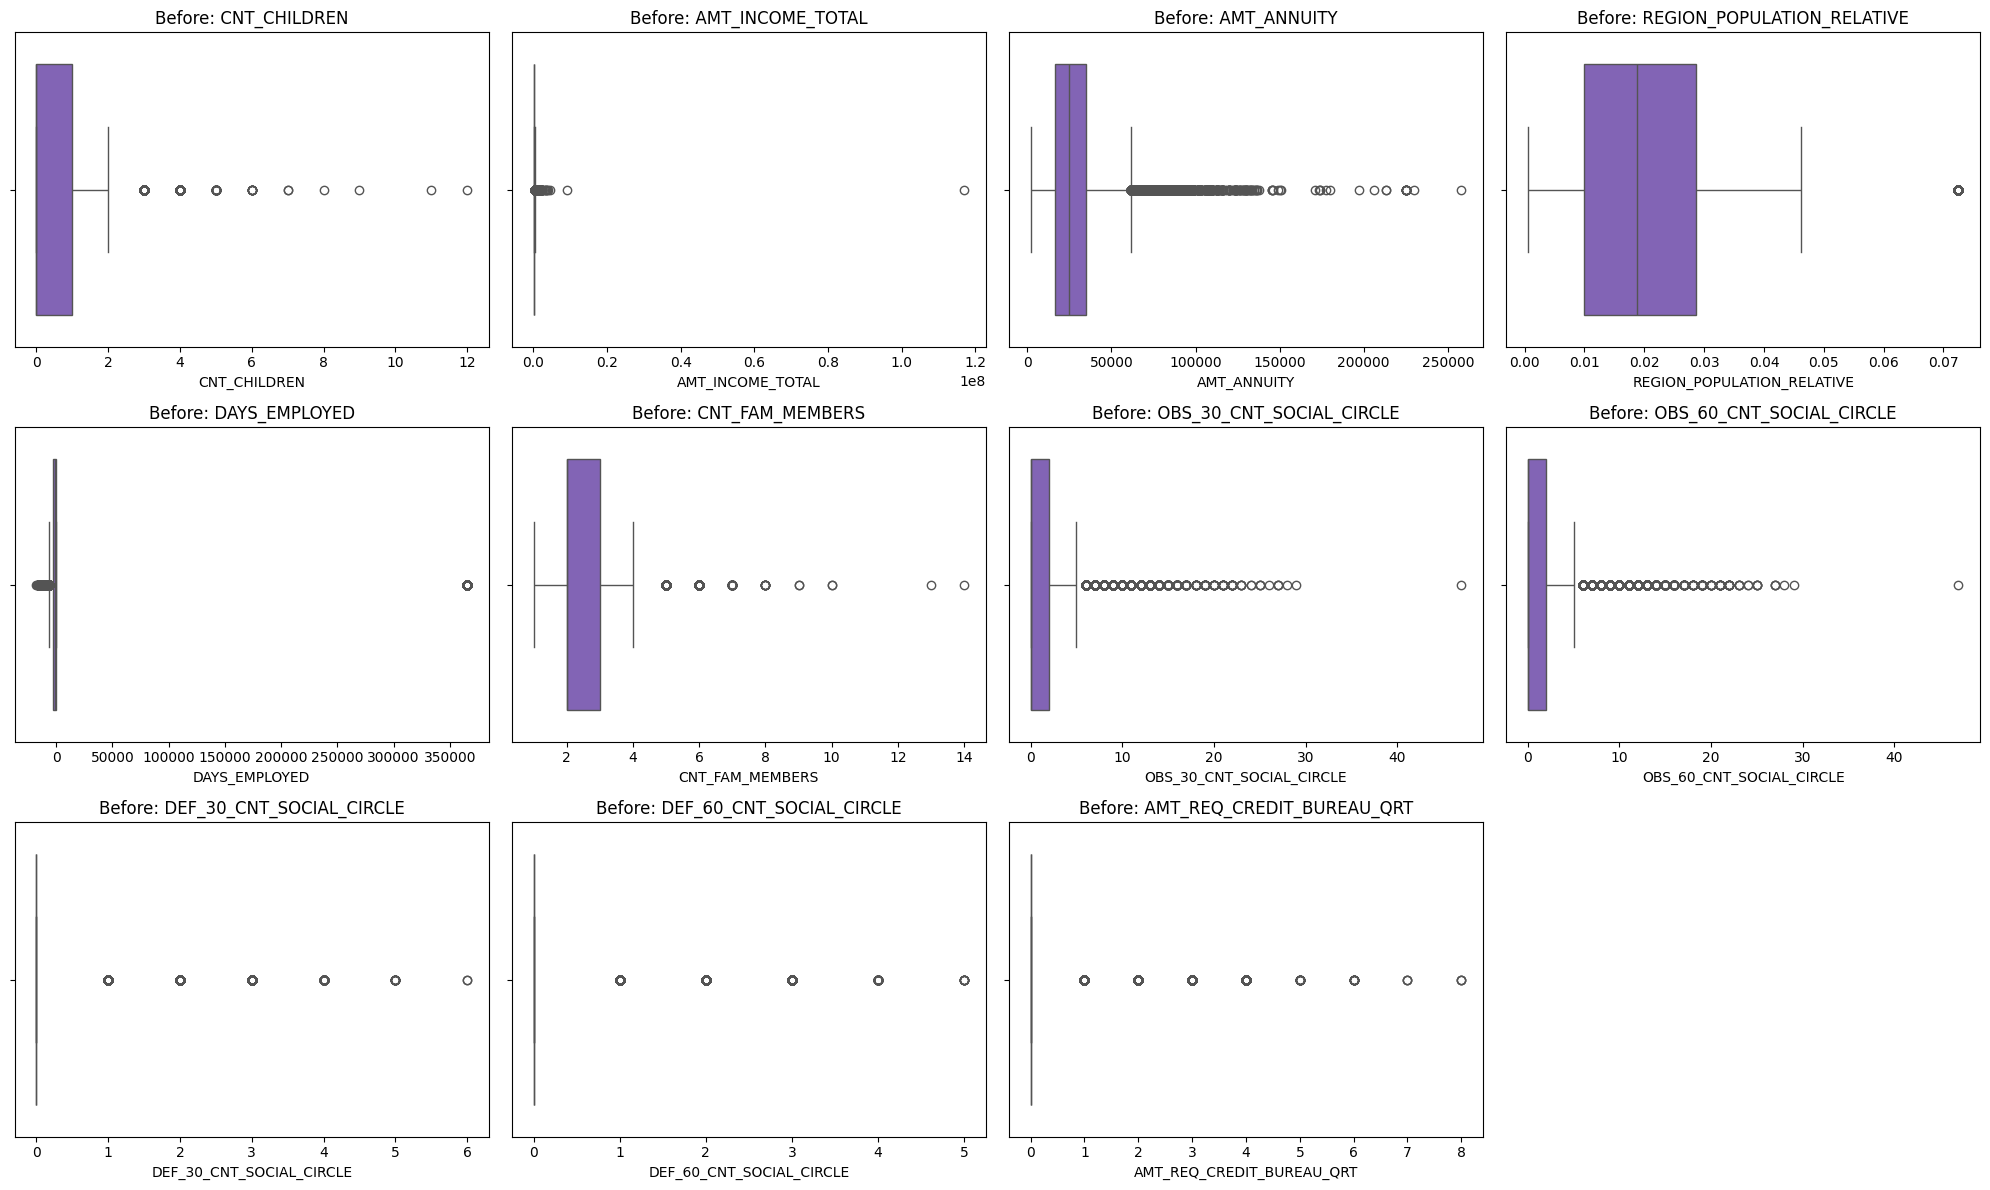

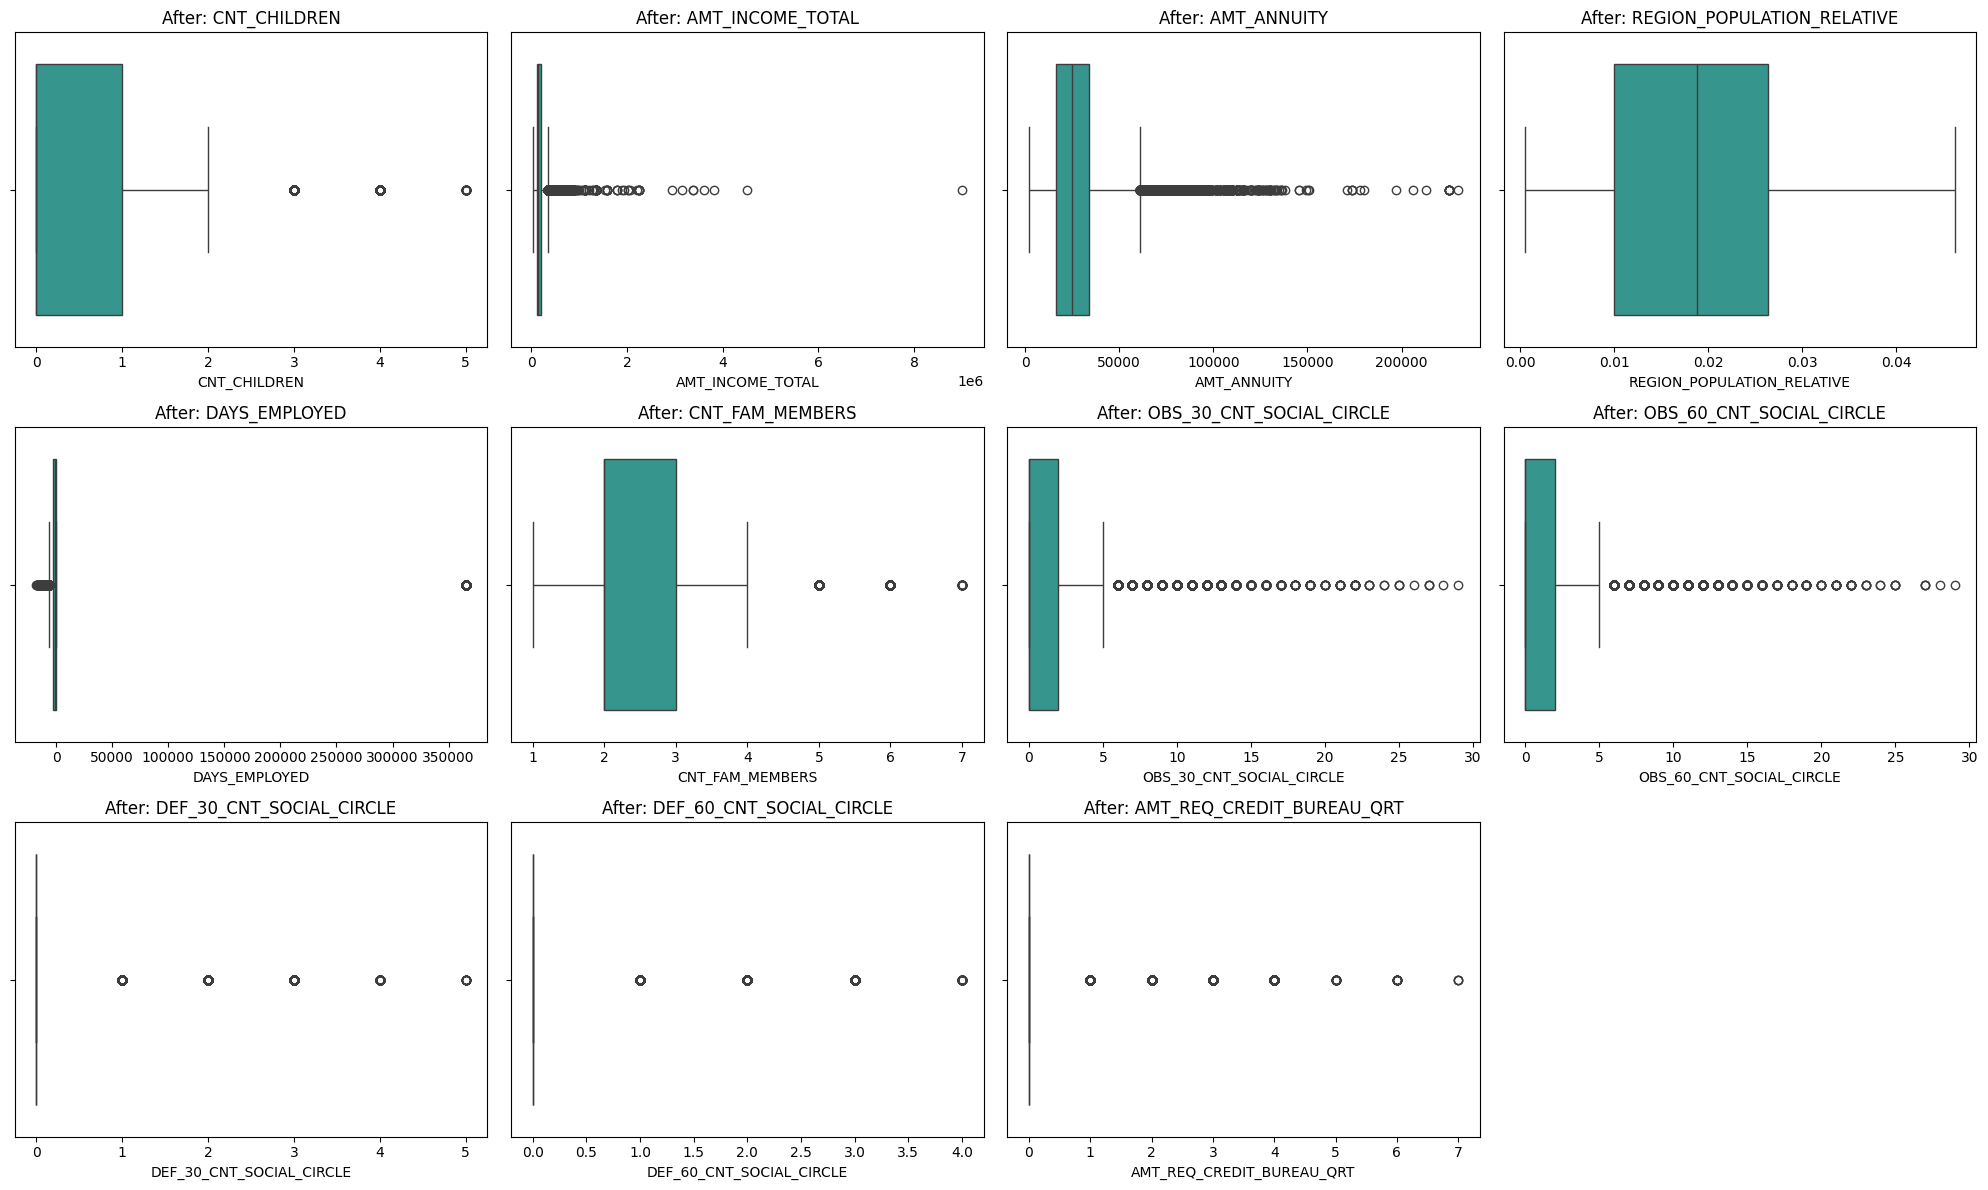

TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0       1         Cash loans           M            N               Y   
1       0         Cash loans           F            N               N   
2       0    Revolving loans           M            Y               Y   
3       0         Cash loans           F            N               Y   
4       0         Cash loans           M            N               Y   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   
2             0           67500.0    135000.0       6750.0         135000.0   
3             0          135000.0    312682.5      29686.5         297000.0   
4             0          121500.0    513000.0      21865.5         513000.0   

   ... AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0  ...                        0.0                       0.0   
1  ...                        0.0                       0.0   
2  ...                        0.0                       0.0   
3  ...                        0.0                       0.0   
4  ...                        0.0                       0.0   

  AMT_REQ_CREDIT_BUREAU_WEEK AMT_REQ_CREDIT_BUREAU_MON  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        0.0                       0.0   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  TARGET_DESC  AGE  \
0                        0.0                         1.0         Risk   25   
1                        0.0                         0.0      No Risk   45   
2                        0.0                         0.0      No Risk   52   
3                        0.0                         1.0      No Risk   52   
4                        0.0                         0.0      No Risk   54   

   AGE_CATEGORY  Marital_status  
0   Young Adult       Unmarried  
1         Adult         Married  
2         Older       Unmarried  
3         Older         Married  
4         Older       Unmarried  

[5 rows x 60 columns]

In [18]:
# === 1) FILTER OUTLIER (hasil sama) ===
# mulai dari salinan numerik
num = df.drop(columns='TARGET').select_dtypes(exclude='object').copy()

# aturan spesifik (sama seperti kode awal)
rules = [
    num['CNT_CHILDREN'] <= 5,
    num['CNT_FAM_MEMBERS'] <= 7,
    num['DAYS_EMPLOYED'] != -365243,
    num['AMT_ANNUITY'] != 258025.5,
    num['AMT_INCOME_TOTAL'] != 1.170000e+08,
]

# buang baris dengan nilai = maksimum pada beberapa kolom
max_drop_cols = [
    'REGION_POPULATION_RELATIVE', 'OBS_30_CNT_SOCIAL_CIRCLE',
    'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
    'DEF_60_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT_BUREAU_QRT'
]
for c in max_drop_cols:
    rules.append(num[c] != num[c].max())

# terapkan semua rule (AND)
mask = rules[0]
for r in rules[1:]:
    mask &= r
num = num[mask]

# === 2) BOX PLOT BEFORE/AFTER (visualisasi) ===
import matplotlib.pyplot as plt
import seaborn as sns

outlier_columns = [
    'CNT_CHILDREN', 'AMT_INCOME_TOTAL','AMT_ANNUITY', 'REGION_POPULATION_RELATIVE',
    'DAYS_EMPLOYED', 'CNT_FAM_MEMBERS', 'OBS_30_CNT_SOCIAL_CIRCLE',
    'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE',
    'AMT_REQ_CREDIT_BUREAU_QRT'
]

plt.figure(figsize=(20, 12))
for i, column in enumerate(outlier_columns, 1):
    plt.subplot(3, 4, i)
    sns.boxplot(x=df[column], color='#7e57c2')  # ungu
    plt.title(f'Before: {column}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 12))
for i, column in enumerate(outlier_columns, 1):
    plt.subplot(3, 4, i)
    sns.boxplot(x=num[column], color='#26a69a')  # teal
    plt.title(f'After: {column}')
plt.tight_layout()
plt.show()

# === 3) APPLY ROW FILTER KE DF UTAMA (hasil sama) ===
df_clean = df.loc[num.index].copy()
df = df_clean.copy()

# === 4) FITUR TURUNAN (hasil sama, versi vektorisasi) ===
# TARGET_DESC
status = {0: 'No Risk', 1: 'Risk'}
df['TARGET_DESC'] = df['TARGET'].replace(status)

# AGE dari DAYS_BIRTH (hari negatif → usia)
df['AGE'] = np.floor(df['DAYS_BIRTH'] / -365).astype(int)
df.drop(columns='DAYS_BIRTH', inplace=True)

# AGE_CATEGORY
df['AGE_CATEGORY'] = np.select(
    [df['AGE'] <= 35, df['AGE'] <= 50],
    ['Young Adult', 'Adult'],
    default='Older'
)

# Marital_status (gabungkan Married & Civil marriage)
df['Marital_status'] = np.where(
    df['NAME_FAMILY_STATUS'].isin(['Married', 'Civil marriage']),
    'Married', 'Unmarried'
)
df.drop(columns='NAME_FAMILY_STATUS', inplace=True)

df.head()


/tmp/ipython-input-1212958648.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['AGE_CATEGORY'], order=order_agecat, ax=axes[1], palette=['#26a69a', '#ffca28', '#ef5350'])


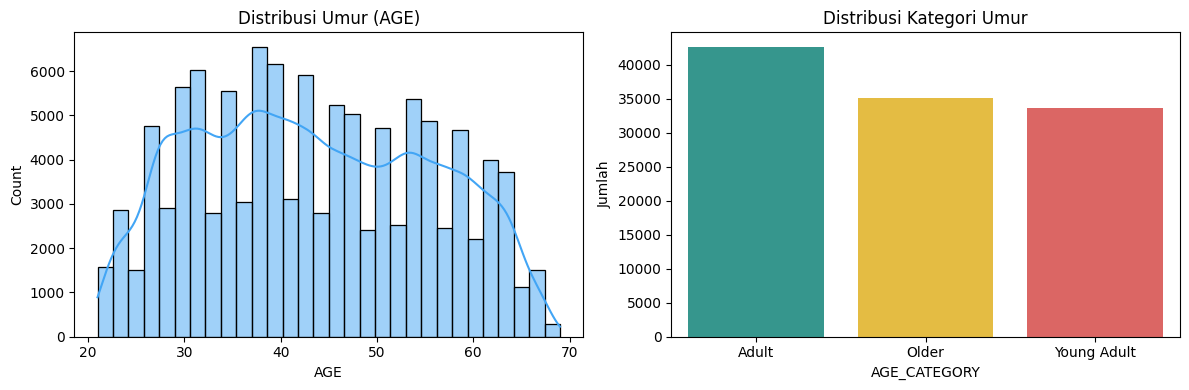

In [19]:
# Distribusi AGE & kategori (2 panel)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram AGE
sns.histplot(df['AGE'], bins=30, kde=True, ax=axes[0], color='#42a5f5')
axes[0].set_title('Distribusi Umur (AGE)')
axes[0].set_xlabel('AGE')

# Countplot AGE_CATEGORY
order_agecat = df['AGE_CATEGORY'].value_counts().index
sns.countplot(x=df['AGE_CATEGORY'], order=order_agecat, ax=axes[1], palette=['#26a69a', '#ffca28', '#ef5350'])
axes[1].set_title('Distribusi Kategori Umur')
axes[1].set_xlabel('AGE_CATEGORY')
axes[1].set_ylabel('Jumlah')

plt.tight_layout()
plt.show()


/tmp/ipython-input-1198056722.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  percentage = value / total[group_index]
/tmp/ipython-input-1198056722.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  percentage = value / total[group_index]
/tmp/ipython-input-1198056722.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  percentage = value / total[group_index]
/tmp/ipython-input-1198056722.py:8: FutureWarning: Series.__getitem__ 

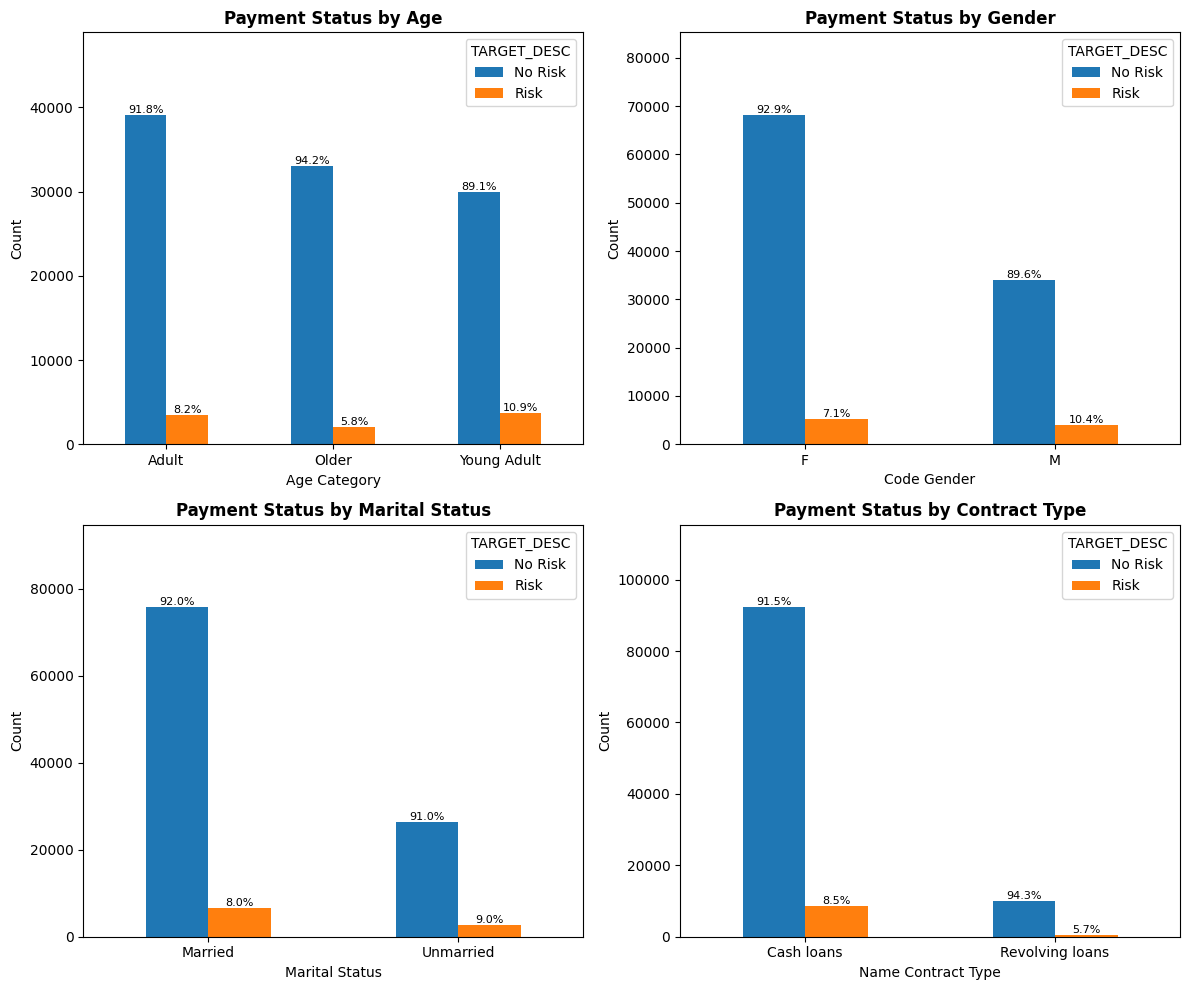

/tmp/ipython-input-1198056722.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  percentage = value / total[group_index]
/tmp/ipython-input-1198056722.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  percentage = value / total[group_index]


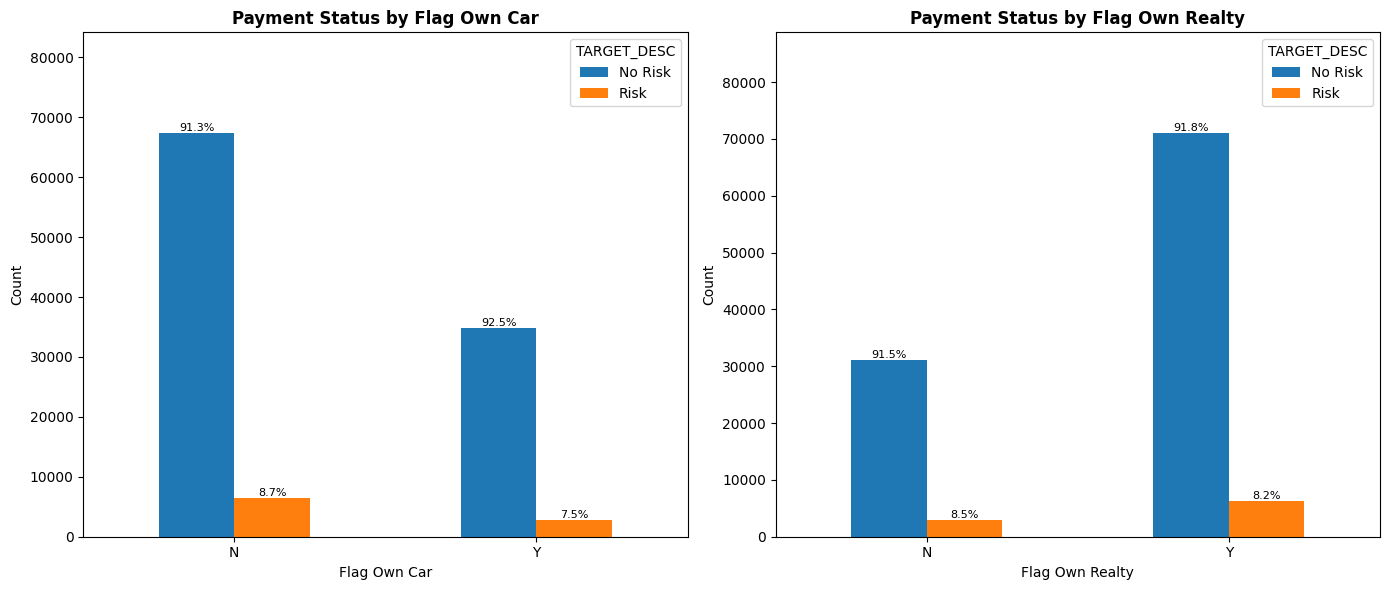

/tmp/ipython-input-1198056722.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  percentage = value / total[group_index]
/tmp/ipython-input-1198056722.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  percentage = value / total[group_index]


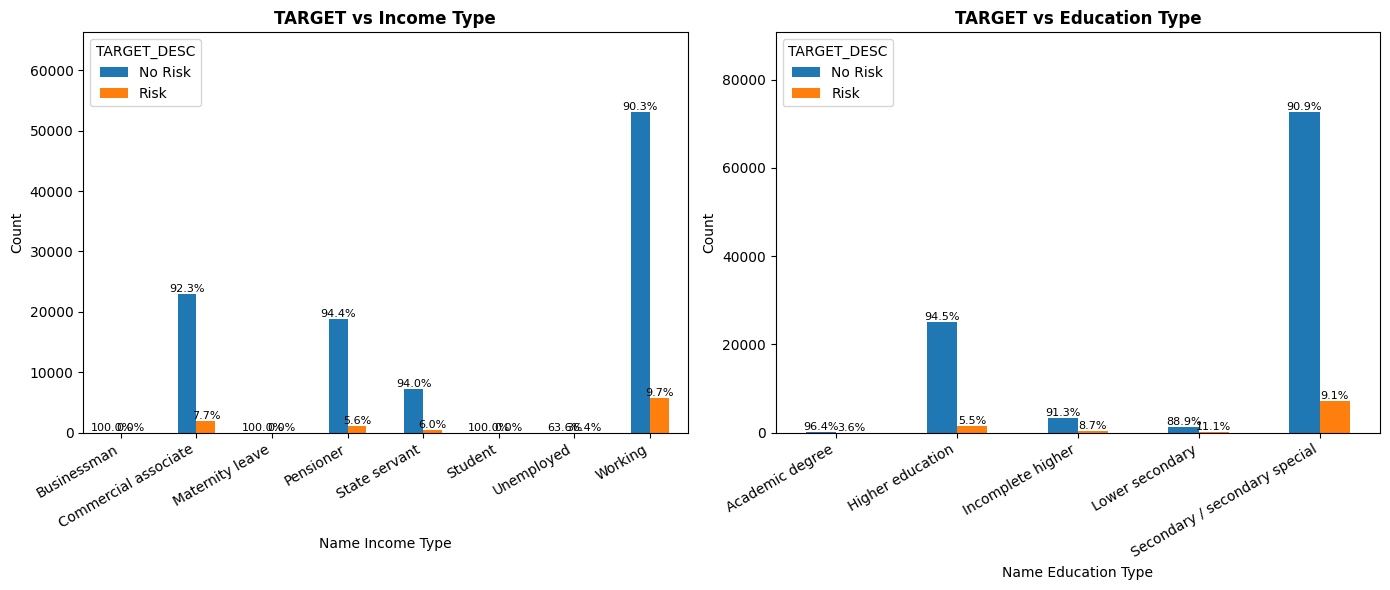


Jumlah berdasarkan NAME_INCOME_TYPE dan TARGET_DESC:
TARGET_DESC                No Risk        Risk
NAME_INCOME_TYPE                              
Businessman              3(100.0%)     0(0.0%)
Commercial associate  23031(92.3%)  1926(7.7%)
Maternity leave          2(100.0%)     0(0.0%)
Pensioner             18810(94.4%)  1107(5.6%)
State servant          7260(94.0%)   460(6.0%)
Student                  9(100.0%)     0(0.0%)
Unemployed                7(63.6%)    4(36.4%)
Working               53030(90.3%)  5706(9.7%)

Jumlah berdasarkan NAME_EDUCATION_TYPE dan TARGET_DESC:
TARGET_DESC                         No Risk        Risk
NAME_EDUCATION_TYPE                                    
Academic degree                   54(96.4%)     2(3.6%)
Higher education               25007(94.5%)  1456(5.5%)
Incomplete higher               3294(91.3%)   312(8.7%)
Lower secondary                 1216(88.9%)  152(11.1%)
Secondary / secondary special  72581(90.9%)  7281(9.1%)


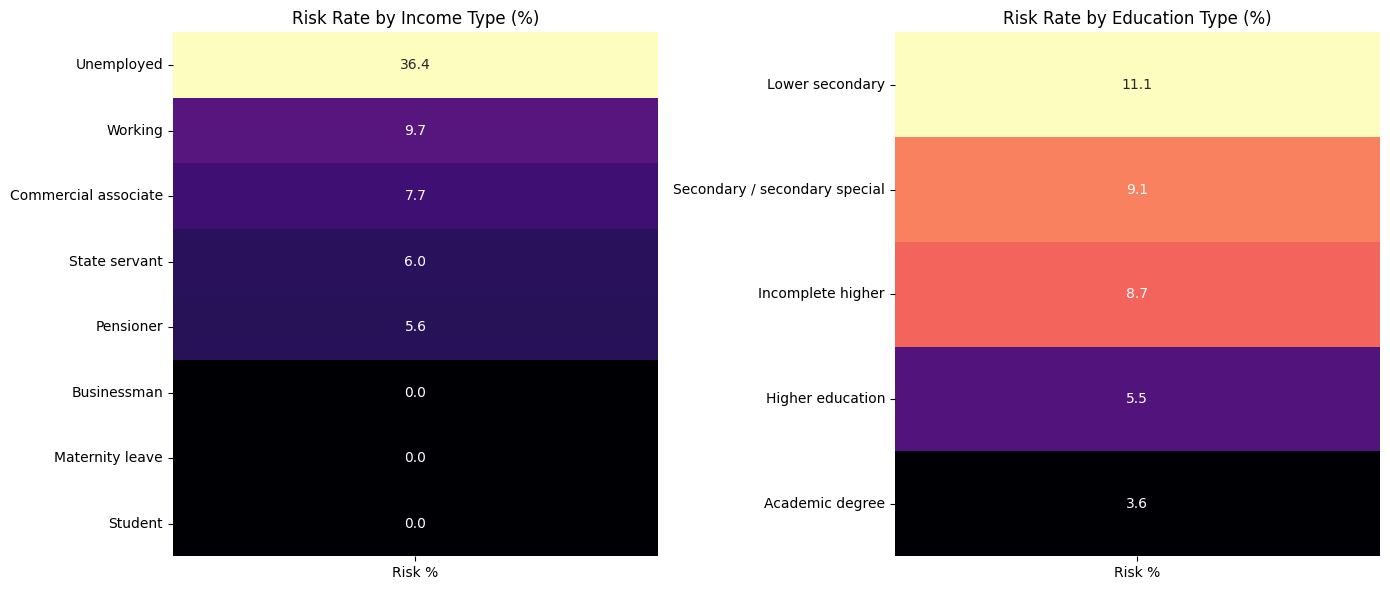

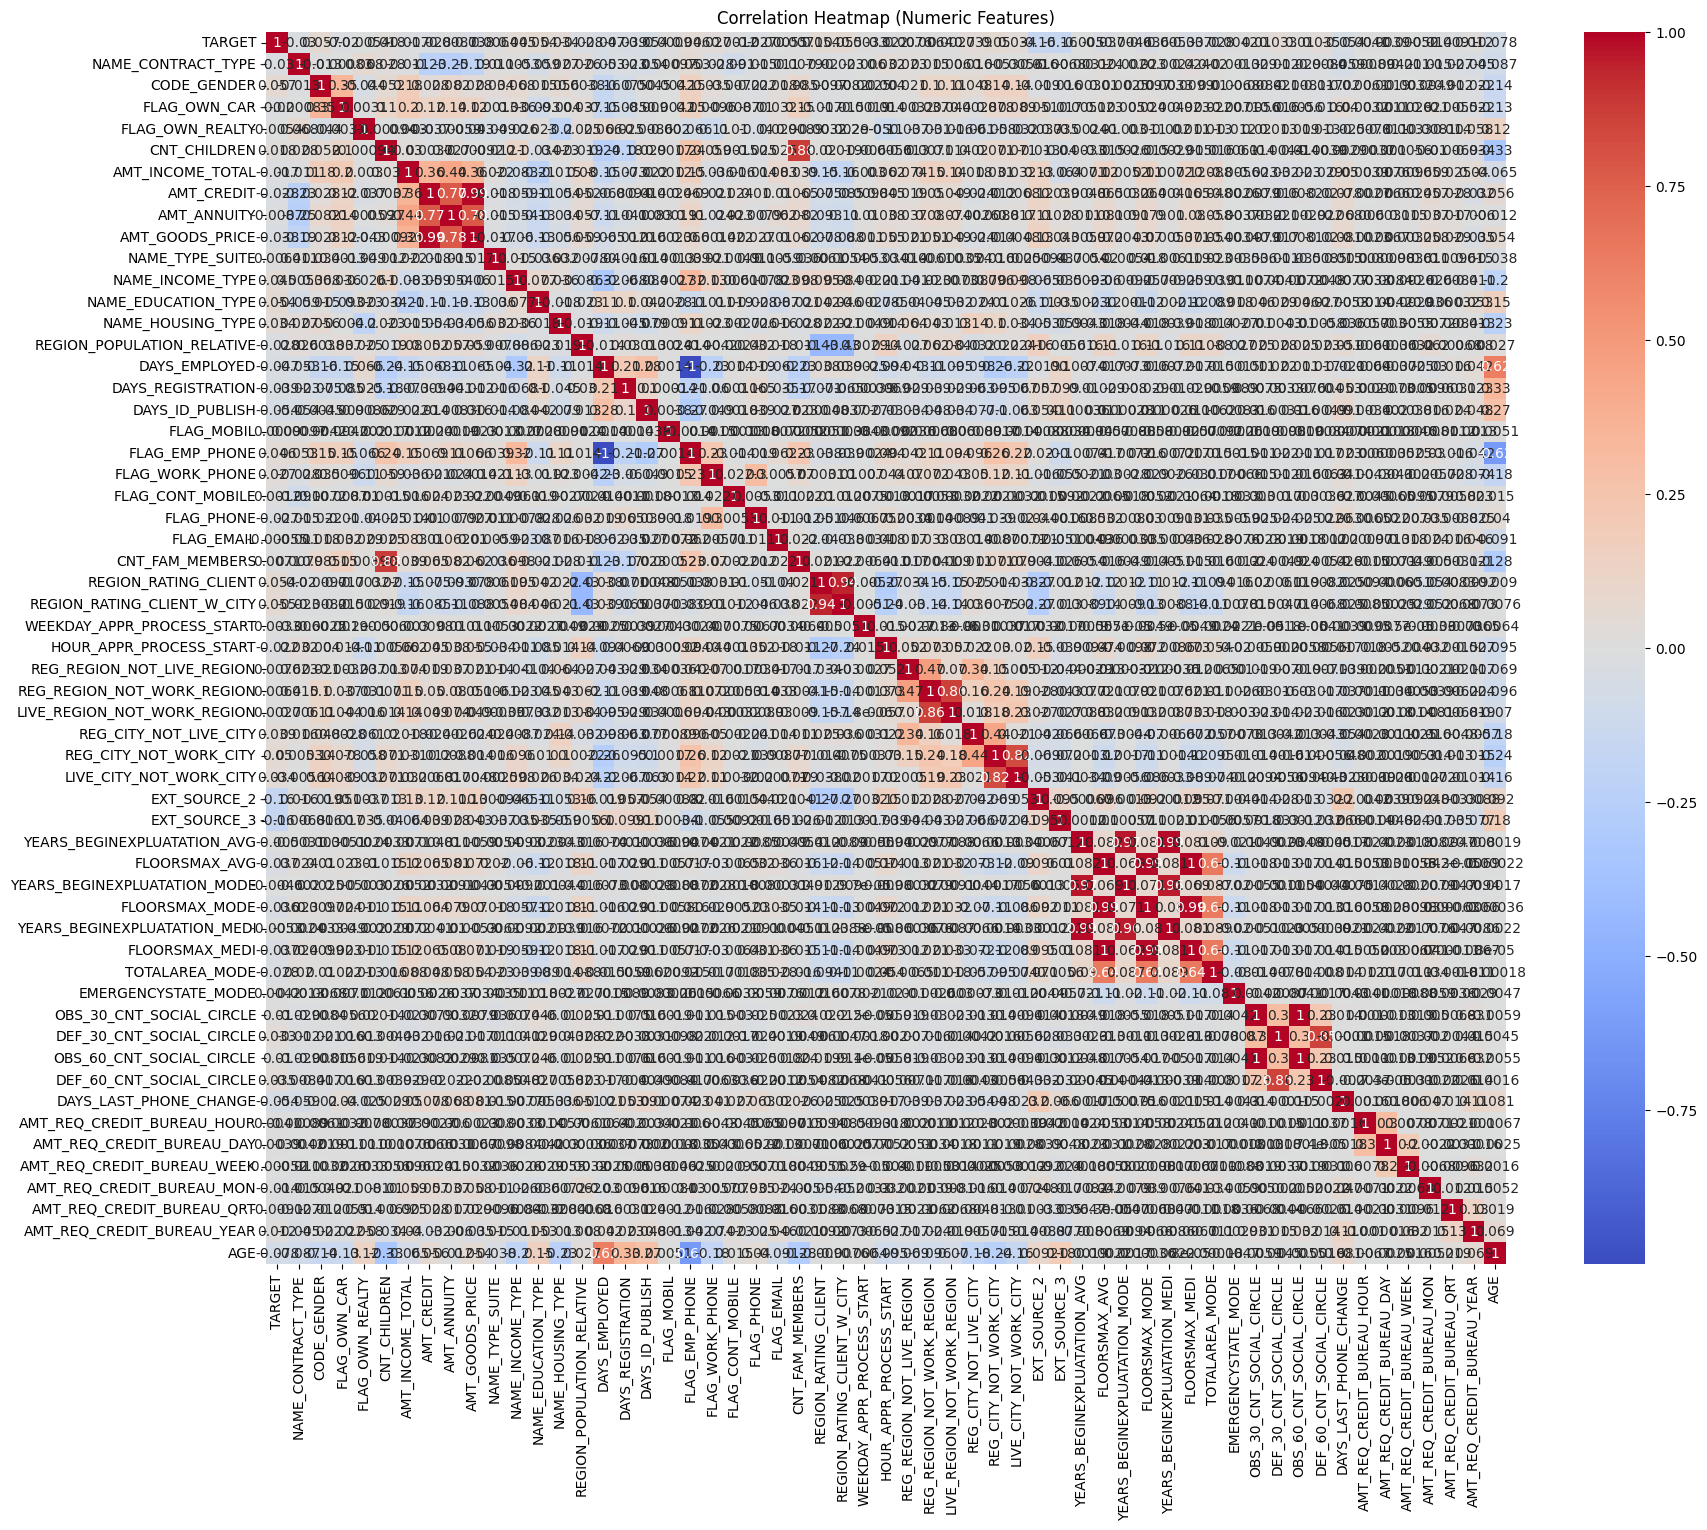

In [20]:
# === util: anotasi persentase di atas bar (sama seperti logika aslimu) ===
def annotate_bars(ax, data):
    total = data.sum(axis=1)
    max_height = 0
    for i, p in enumerate(ax.patches):
        group_index = i % len(total)
        value = p.get_height()
        percentage = value / total[group_index]
        ax.annotate(f'{percentage:.1%}',
                    (p.get_x() + p.get_width() / 2., value + 2),
                    ha='center', va='bottom', fontsize=8, color='black')
        max_height = max(max_height, value)
    ax.set_ylim(0, max_height * 1.25)

# === util: plot grouped bar (groupby + unstack) dengan palet konsisten ===
PALETTE = ['#1f77b4', '#ff7f0e']  # No Risk / Risk

def plot_grouped_bar(df, x, hue='TARGET_DESC', ax=None, title=''):
    data = df.groupby([x, hue]).size().unstack()
    axis = data.plot(kind='bar', ax=ax, color=PALETTE)
    axis.set_xticklabels(axis.get_xticklabels(), rotation=0)
    axis.set_xlabel(x.replace('_', ' ').title())
    axis.set_ylabel('Count')
    axis.set_title(title, weight='bold')
    annotate_bars(axis, data)
    return axis

# === Grid 2x2: Age, Gender, Marital, Contract (hasil sama, gaya rapi) ===
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
plot_grouped_bar(df, 'AGE_CATEGORY', ax=axes[0, 0], title='Payment Status by Age')
plot_grouped_bar(df, 'CODE_GENDER', ax=axes[0, 1], title='Payment Status by Gender')
plot_grouped_bar(df, 'Marital_status', ax=axes[1, 0], title='Payment Status by Marital Status')
plot_grouped_bar(df, 'NAME_CONTRACT_TYPE', ax=axes[1, 1], title='Payment Status by Contract Type')
plt.tight_layout()
plt.show()

# === Grid 1x2: Flag mobil & realty (hasil sama, gaya rapi) ===
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_grouped_bar(df, 'FLAG_OWN_CAR', ax=axes[0], title='Payment Status by Flag Own Car')
plot_grouped_bar(df, 'FLAG_OWN_REALTY', ax=axes[1], title='Payment Status by Flag Own Realty')
plt.tight_layout()
plt.show()

# === Grid 1x2: Income type & Education (hasil sama, gaya rapi) ===
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_grouped_bar(df, 'NAME_INCOME_TYPE', ax=axes[0], title='TARGET vs Income Type')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=30, ha='right')
plot_grouped_bar(df, 'NAME_EDUCATION_TYPE', ax=axes[1], title='TARGET vs Education Type')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=30, ha='right')
plt.tight_layout()
plt.show()

# === Tabel jumlah + persentase (hasil sama, gaya rapi) ===
target_income = df.groupby(['NAME_INCOME_TYPE', 'TARGET_DESC']).size().unstack().fillna(0)
target_income_percent = target_income.div(target_income.sum(axis=1), axis=0) * 100
combined_income = target_income.astype(int).astype(str) + '(' + target_income_percent.round(1).astype(str) + '%)'
print("\nJumlah berdasarkan NAME_INCOME_TYPE dan TARGET_DESC:")
print(combined_income)

target_education = df.groupby(['NAME_EDUCATION_TYPE', 'TARGET_DESC']).size().unstack().fillna(0)
target_education_percent = target_education.div(target_education.sum(axis=1), axis=0) * 100
combined_education = target_education.astype(int).astype(str) + '(' + target_education_percent.round(1).astype(str) + '%)'
print("\nJumlah berdasarkan NAME_EDUCATION_TYPE dan TARGET_DESC:")
print(combined_education)

# === Visualisasi tambahan (baru): heatmap Risk Rate (tidak mengubah hasil) ===
# memplot persentase "Risk" per kategori agar pola lebih jelas sekilas
risk_rate_income = target_income_percent.get('Risk', pd.Series(0, index=target_income_percent.index)).to_frame('Risk %')
risk_rate_edu = target_education_percent.get('Risk', pd.Series(0, index=target_education_percent.index)).to_frame('Risk %')

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.heatmap(risk_rate_income.sort_values('Risk %', ascending=False), annot=True, fmt='.1f', cmap='magma', cbar=False, ax=axes[0])
axes[0].set_title('Risk Rate by Income Type (%)')

sns.heatmap(risk_rate_edu.sort_values('Risk %', ascending=False), annot=True, fmt='.1f', cmap='magma', cbar=False, ax=axes[1])
axes[1].set_title('Risk Rate by Education Type (%)')

for ax in axes:
    ax.set_xlabel('')
    ax.set_ylabel('')
plt.tight_layout()
plt.show()

# === Transformasi hari (abs) — tetap sama ===
df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].abs()
df['DAYS_REGISTRATION'] = df['DAYS_REGISTRATION'].abs()
df['DAYS_ID_PUBLISH'] = df['DAYS_ID_PUBLISH'].abs()
df['DAYS_LAST_PHONE_CHANGE'] = df['DAYS_LAST_PHONE_CHANGE'].abs()

# === Label encoding copy (hasil sama) ===
cat = df.select_dtypes(include='object').columns.tolist()
df_copy = df.copy()
df_copy[cat] = df_copy[cat].apply(LabelEncoder().fit_transform)
df_copy = df_copy.drop(columns=['AGE_CATEGORY', 'TARGET_DESC', 'Marital_status']).dropna()

# === Heatmap korelasi numerik (tetap sama, warna diseragamkan) ===
plt.figure(figsize=(20, 16))
sns.heatmap(df_copy.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap (Numeric Features)')
plt.show()

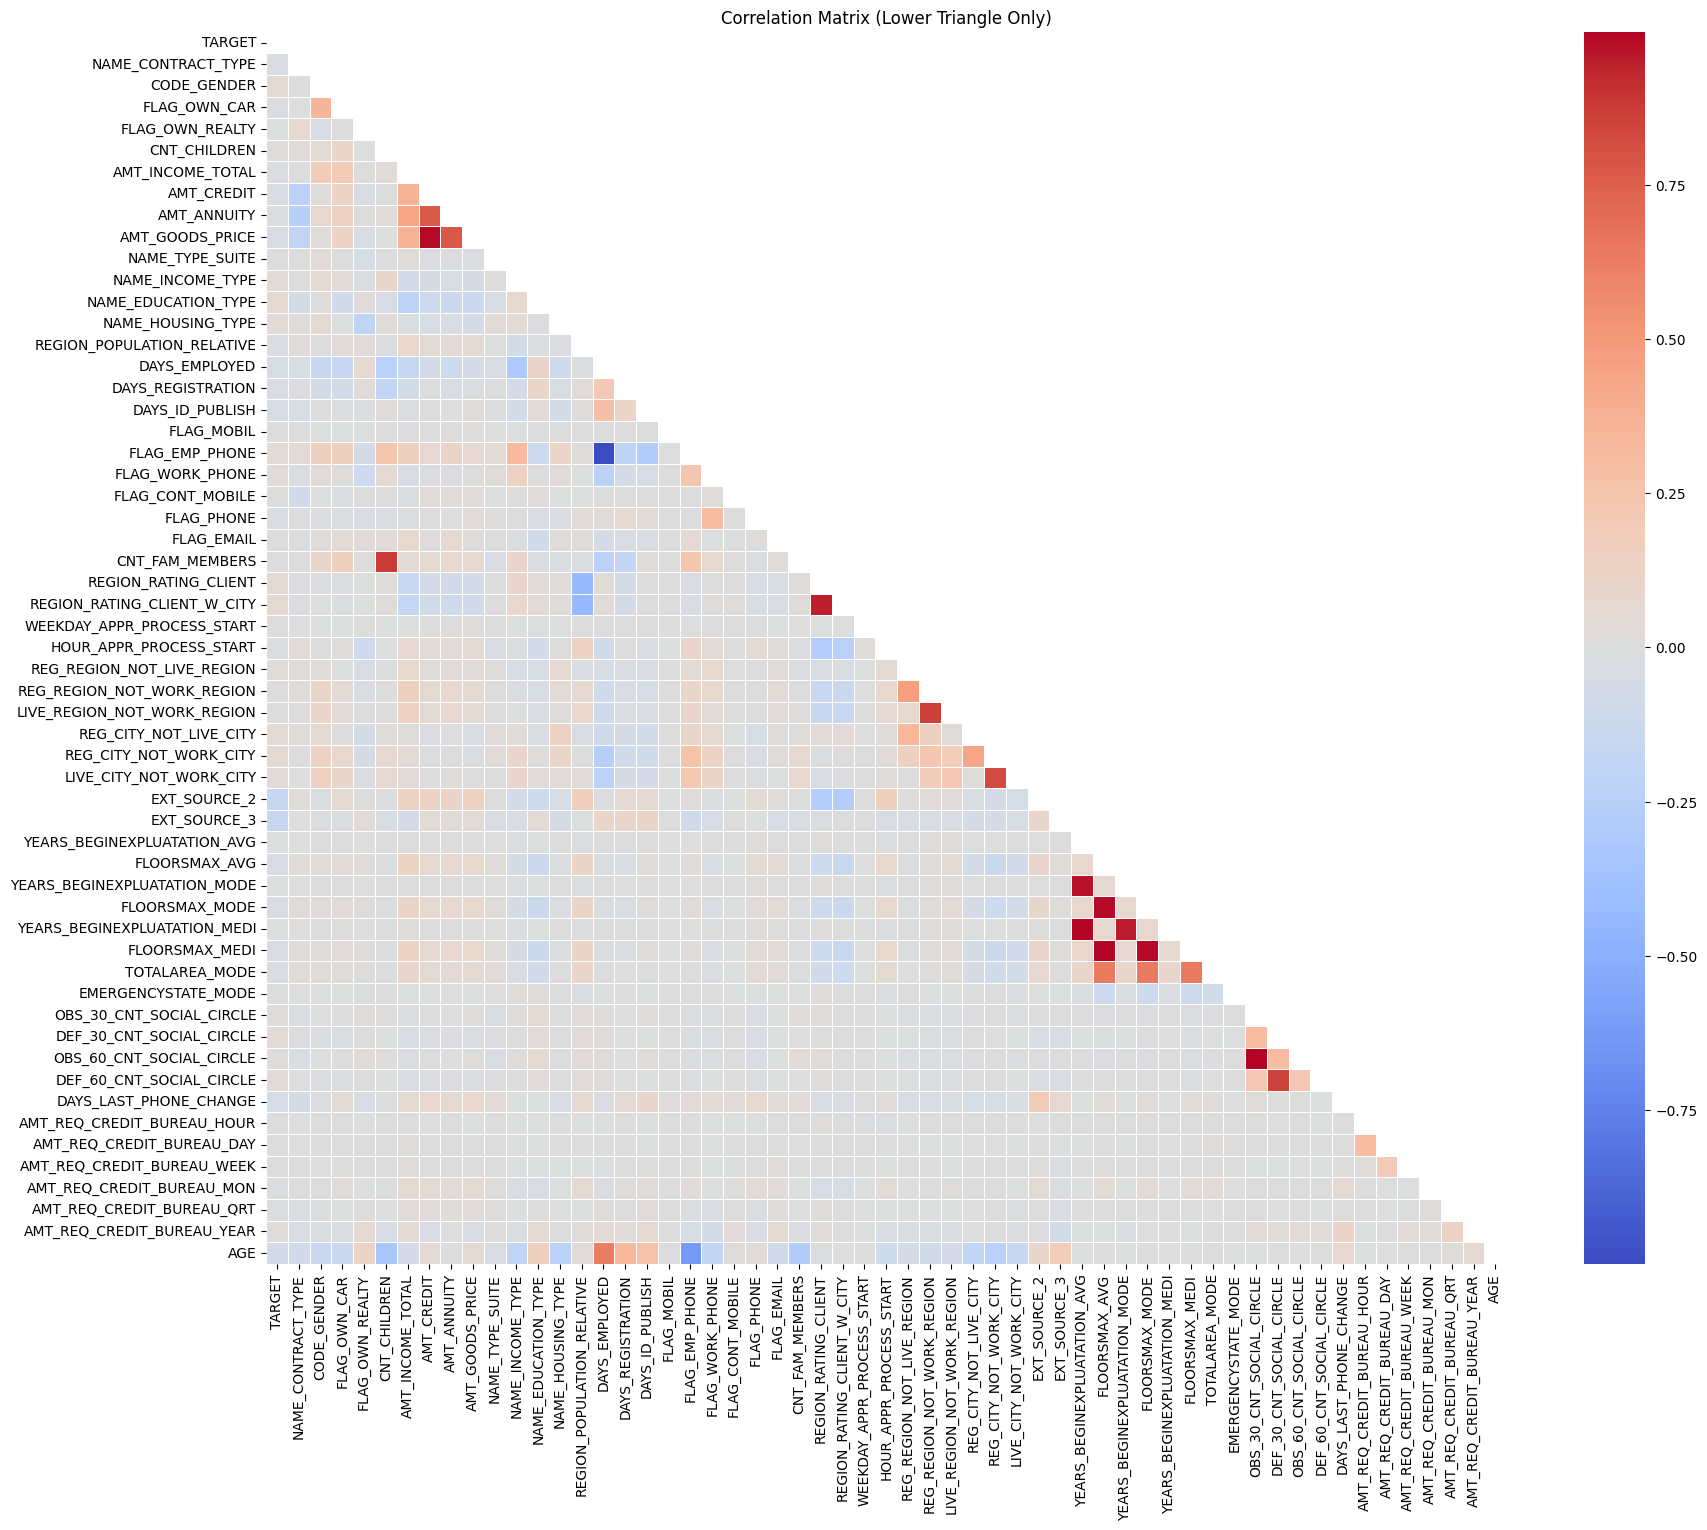

CNT_CHILDREN dan CNT_FAM_MEMBERS: 0.88
AMT_CREDIT dan AMT_GOODS_PRICE: 0.99
DAYS_EMPLOYED dan FLAG_EMP_PHONE: 1.00
REGION_RATING_CLIENT dan REGION_RATING_CLIENT_W_CITY: 0.94
REG_REGION_NOT_WORK_REGION dan LIVE_REGION_NOT_WORK_REGION: 0.86
REG_CITY_NOT_WORK_CITY dan LIVE_CITY_NOT_WORK_CITY: 0.82
YEARS_BEGINEXPLUATATION_AVG dan YEARS_BEGINEXPLUATATION_MODE: 0.97
YEARS_BEGINEXPLUATATION_AVG dan YEARS_BEGINEXPLUATATION_MEDI: 0.99
FLOORSMAX_AVG dan FLOORSMAX_MODE: 0.99
FLOORSMAX_AVG dan FLOORSMAX_MEDI: 1.00
YEARS_BEGINEXPLUATATION_MODE dan YEARS_BEGINEXPLUATATION_MEDI: 0.96
FLOORSMAX_MODE dan FLOORSMAX_MEDI: 0.99
OBS_30_CNT_SOCIAL_CIRCLE dan OBS_60_CNT_SOCIAL_CIRCLE: 1.00
DEF_30_CNT_SOCIAL_CIRCLE dan DEF_60_CNT_SOCIAL_CIRCLE: 0.85


In [21]:
# === Correlation (gaya rapi, hasil sama) ===
# hitung sekali lalu pakai ulang
corr = df_copy.corr()                     # = numeric-only corr (default)
corr_abs = corr.abs()

# mask segitiga atas
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(20, 16))
sns.heatmap(
    corr, mask=mask, cmap='coolwarm', annot=False, fmt='.2f', linewidths=0.5
)
plt.title('Correlation Matrix (Lower Triangle Only)')
plt.show()

# === High-corr pairs (hasil sama) ===
threshold = 0.8
corr_matrix = corr_abs

ix = np.where(corr_matrix > threshold)
high_corr_var = [
    (corr_matrix.columns[i], corr_matrix.columns[j])
    for i, j in zip(*ix) if i != j and i < j
]

for a, b in high_corr_var:
    print(f"{a} dan {b}: {corr_matrix.loc[a, b]:.2f}")


In [22]:
# === Drop columns (tetap persis sama) ===
df_copy = df_copy.drop(columns=[
    'CNT_FAM_MEMBERS','AMT_GOODS_PRICE','REGION_RATING_CLIENT_W_CITY',
    'LIVE_REGION_NOT_WORK_REGION','YEARS_BEGINEXPLUATATION_MODE',
    'YEARS_BEGINEXPLUATATION_MEDI','FLOORSMAX_MODE','FLOORSMAX_MEDI',
    'OBS_60_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE'
])

df_copy = df_copy.drop(columns=['LIVE_CITY_NOT_WORK_CITY'])
df_copy.head()


TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0       1                   0            1             0                1   
1       0                   0            0             0                0   
2       0                   1            1             1                1   
3       0                   0            0             0                1   
4       0                   0            1             0                1   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  NAME_TYPE_SUITE  \
0             0          202500.0    406597.5      24700.5                6   
1             0          270000.0   1293502.5      35698.5                1   
2             0           67500.0    135000.0       6750.0                6   
3             0          135000.0    312682.5      29686.5                6   
4             0          121500.0    513000.0      21865.5                6   

   ...  OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
0  ...                       2.0                       2.0   
1  ...                       1.0                       0.0   
2  ...                       0.0                       0.0   
3  ...                       2.0                       0.0   
4  ...                       0.0                       0.0   

   DAYS_LAST_PHONE_CHANGE  AMT_REQ_CREDIT_BUREAU_HOUR  \
0                  1134.0                         0.0   
1                   828.0                         0.0   
2                   815.0                         0.0   
3                   617.0                         0.0   
4                  1106.0                         0.0   

   AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_WEEK  \
0                        0.0                         0.0   
1                        0.0                         0.0   
2                        0.0                         0.0   
3                        0.0                         0.0   
4                        0.0                         0.0   

   AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_QRT  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_YEAR  AGE  
0                         1.0   25  
1                         0.0   45  
2                         0.0   52  
3                         1.0   52  
4                         0.0   54  

[5 rows x 46 columns]

In [23]:
# === Feature matrix & target (hasil sama) ===
X = df_copy.drop('TARGET', axis=1)
y = df_copy['TARGET']

# Univariate selection (hasil sama)
features_selected = SelectKBest(score_func=chi2, k=15)
fit = features_selected.fit(X, y)

df_scores   = pd.DataFrame(fit.scores_,  columns=['Score'])
df_pvalues  = pd.DataFrame(fit.pvalues_, columns=['P-Value'])
df_columns  = pd.DataFrame(X.columns,    columns=['Features'])

feature_scores = pd.concat([df_columns, df_scores, df_pvalues], axis=1)
print('The features that correlate well with target feature:\n')
feature_scores.sort_values(by='Score', ascending=False)

# filter p-value < 0.05 (hasil sama)
feature_fix = feature_scores[feature_scores['P-Value'] < 0.05]
features = feature_fix['Features'].to_list()
number_features = len(features)
print(f'the number of important features = {number_features}')
features

# update X (hasil sama)
X = df_copy[features]
X.head()


The features that correlate well with target feature:

the number of important features = 33


NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0                   0            1             0             0   
1                   0            0             0             0   
2                   1            1             1             0   
3                   0            0             0             0   
4                   0            1             0             0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  NAME_INCOME_TYPE  \
0          202500.0    406597.5      24700.5                 7   
1          270000.0   1293502.5      35698.5                 4   
2           67500.0    135000.0       6750.0                 7   
3          135000.0    312682.5      29686.5                 7   
4          121500.0    513000.0      21865.5                 7   

   NAME_EDUCATION_TYPE  NAME_HOUSING_TYPE  ...  EXT_SOURCE_3  FLOORSMAX_AVG  \
0                    4                  1  ...      0.139376         0.0833   
1                    1                  1  ...      0.535276         0.2917   
2                    4                  1  ...      0.729567         0.1667   
3                    4                  1  ...      0.535276         0.1667   
4                    4                  1  ...      0.535276         0.1667   

   TOTALAREA_MODE  OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
0          0.0149                       2.0                       2.0   
1          0.0714                       1.0                       0.0   
2          0.0686                       0.0                       0.0   
3          0.0686                       2.0                       0.0   
4          0.0686                       0.0                       0.0   

   DAYS_LAST_PHONE_CHANGE  AMT_REQ_CREDIT_BUREAU_MON  \
0                  1134.0                        0.0   
1                   828.0                        0.0   
2                   815.0                        0.0   
3                   617.0                        0.0   
4                  1106.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  AGE  
0                        0.0                         1.0   25  
1                        0.0                         0.0   45  
2                        0.0                         0.0   52  
3                        0.0                         1.0   52  
4                        0.0                         0.0   54  

[5 rows x 33 columns]

In [24]:
# === Scaling + SMOTE + Split (hasil sama) ===
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)

# simpan distribusi sebelum SMOTE untuk visualisasi
y_before = y.value_counts()

X_res, y_res = smote.fit_resample(X, y)
print(y_res.value_counts())

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.3, random_state=42
)

print(len(X_train))
print(len(X_test))


TARGET
1    102152
0    102152
Name: count, dtype: int64
143012
61292


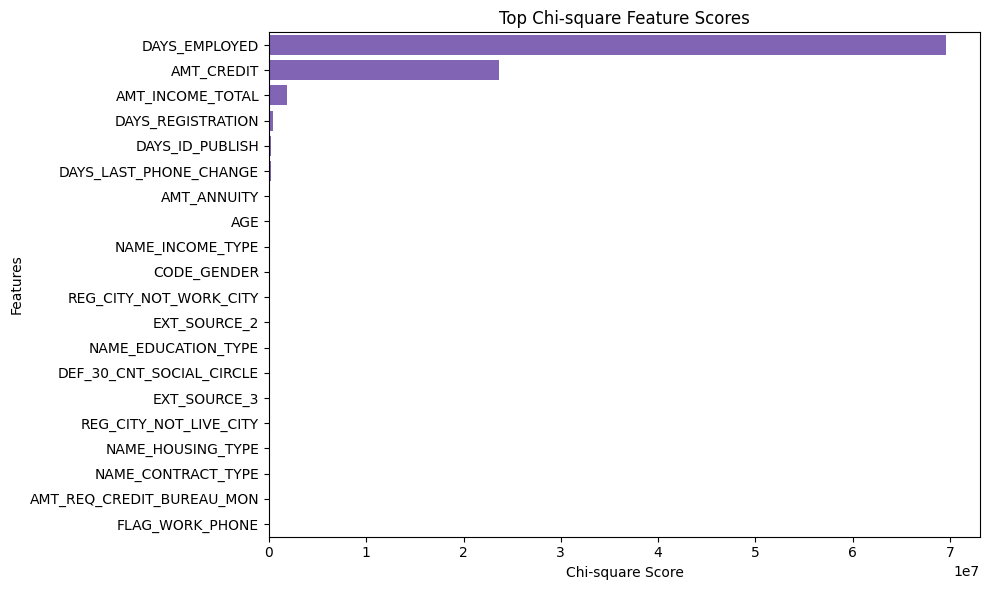

In [25]:
# 1) Barplot skor chi² (top N)
TOP_N = min(20, len(feature_scores))  # aman jika fitur sedikit
fs_plot = feature_scores.sort_values('Score', ascending=False).head(TOP_N)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=fs_plot, y='Features', x='Score', color='#7e57c2'
)
plt.title('Top Chi-square Feature Scores')
plt.xlabel('Chi-square Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


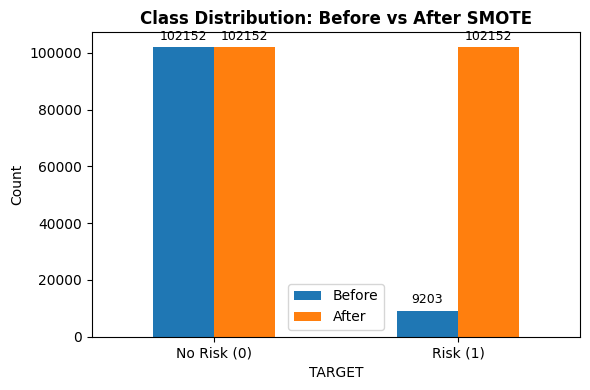

In [26]:
# 2) Perbandingan kelas sebelum vs sesudah SMOTE
comp = (
    pd.DataFrame({'Before': y_before, 'After': y_res.value_counts()})
      .reindex([0, 1])  # pastikan urutan No Risk (0), Risk (1)
      .fillna(0).astype(int)
)

ax = comp.plot(kind='bar', figsize=(6, 4), color=['#1f77b4', '#ff7f0e'])
ax.set_xticklabels(['No Risk (0)', 'Risk (1)'], rotation=0)
ax.set_ylabel('Count')
ax.set_title('Class Distribution: Before vs After SMOTE', weight='bold')

# anotasi angka
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}",
                (p.get_x() + p.get_width()/2, p.get_height()),
                ha='center', va='bottom', fontsize=9, xytext=(0, 3), textcoords='offset points')

plt.tight_layout()
plt.show()


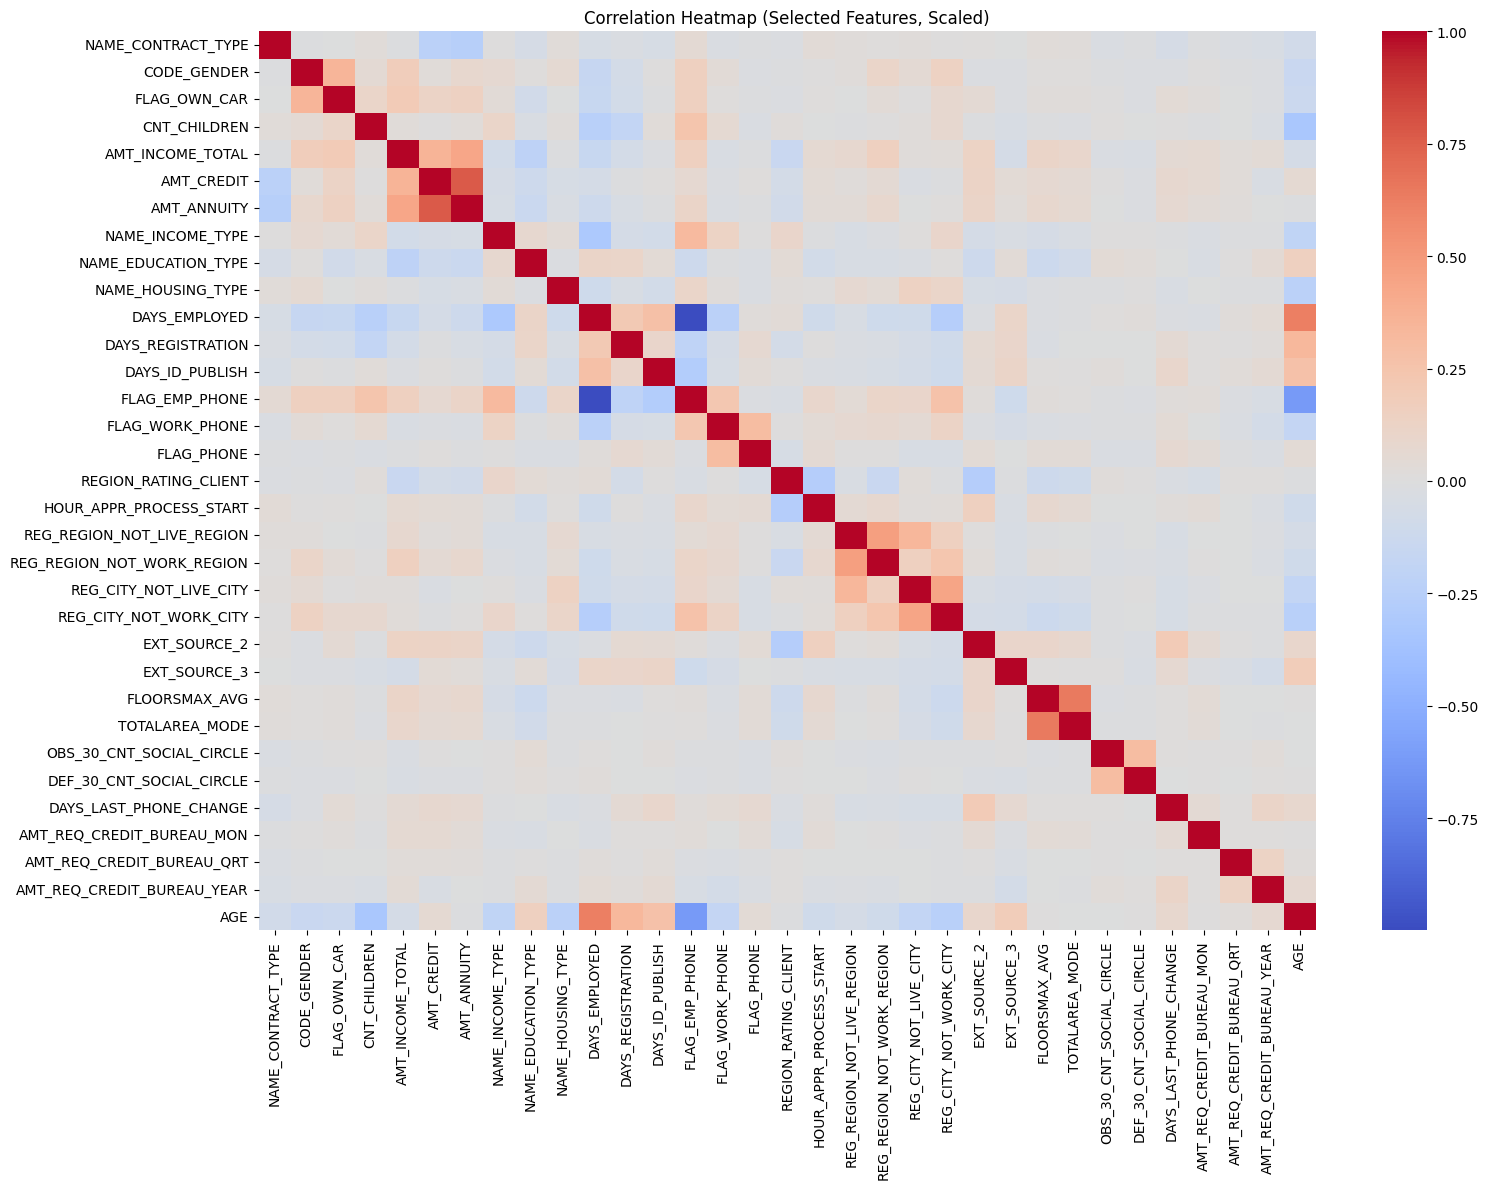

In [27]:
# 3) (opsional) Heatmap korelasi fitur terpilih (lebih kecil & fokus)
if number_features > 1:
    sel_df = pd.DataFrame(X, columns=features)  # X sudah terskala; visual hanya
    plt.figure(figsize=(min(1.2*number_features, 16), min(1.2*number_features, 12)))
    sns.heatmap(sel_df.corr(), cmap='coolwarm', annot=False)
    plt.title('Correlation Heatmap (Selected Features, Scaled)')
    plt.tight_layout()
    plt.show()



Logistic Regression - Classification Report
              precision    recall  f1-score   support

           0       0.68      0.69      0.68     30624
           1       0.68      0.68      0.68     30668

    accuracy                           0.68     61292
   macro avg       0.68      0.68      0.68     61292
weighted avg       0.68      0.68      0.68     61292



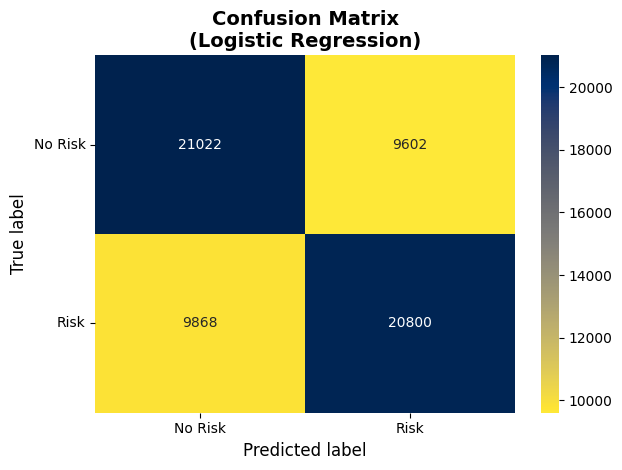

Logistic Regression ROC AUC: 0.68234

Naive Bayes (Multinomial) - Classification Report
              precision    recall  f1-score   support

           0       0.61      0.61      0.61     30624
           1       0.61      0.62      0.62     30668

    accuracy                           0.61     61292
   macro avg       0.61      0.61      0.61     61292
weighted avg       0.61      0.61      0.61     61292



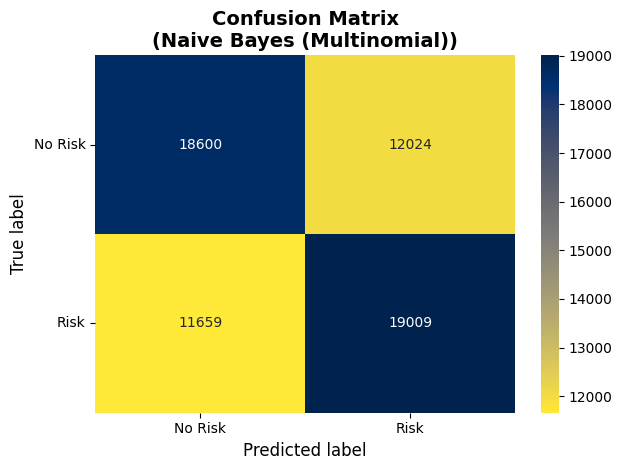

Naive Bayes (Multinomial) ROC AUC: 0.6136

K-Nearest Neighbors - Classification Report
              precision    recall  f1-score   support

           0       0.99      0.67      0.80     30624
           1       0.75      1.00      0.86     30668

    accuracy                           0.83     61292
   macro avg       0.87      0.83      0.83     61292
weighted avg       0.87      0.83      0.83     61292



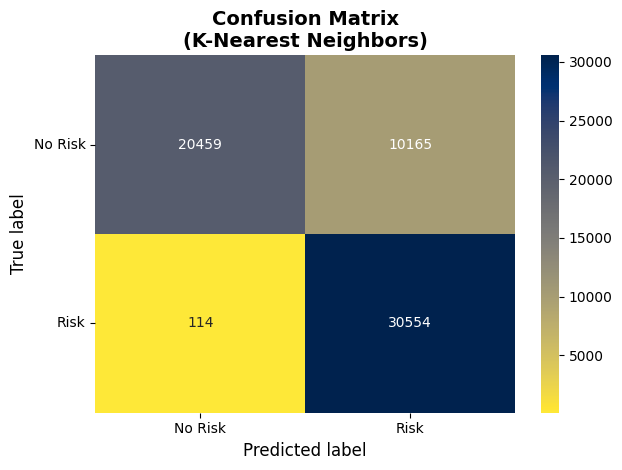

K-Nearest Neighbors ROC AUC: 0.83218

Decision Tree - Classification Report
              precision    recall  f1-score   support

           0       0.90      0.88      0.89     30624
           1       0.88      0.90      0.89     30668

    accuracy                           0.89     61292
   macro avg       0.89      0.89      0.89     61292
weighted avg       0.89      0.89      0.89     61292



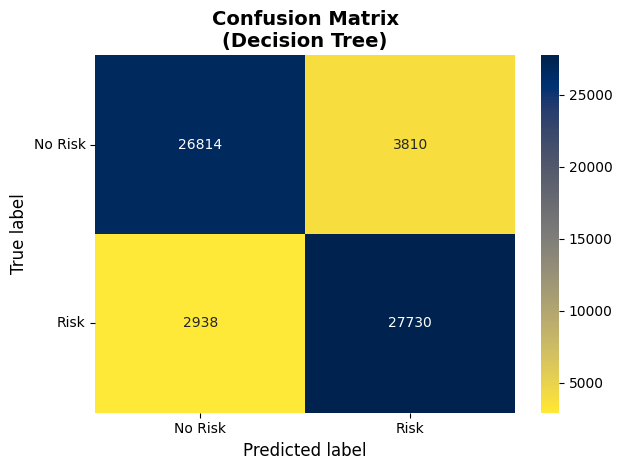

Decision Tree ROC AUC: 0.88989

Random Forest - Classification Report
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     30624
           1       0.99      0.92      0.95     30668

    accuracy                           0.95     61292
   macro avg       0.96      0.95      0.95     61292
weighted avg       0.96      0.95      0.95     61292



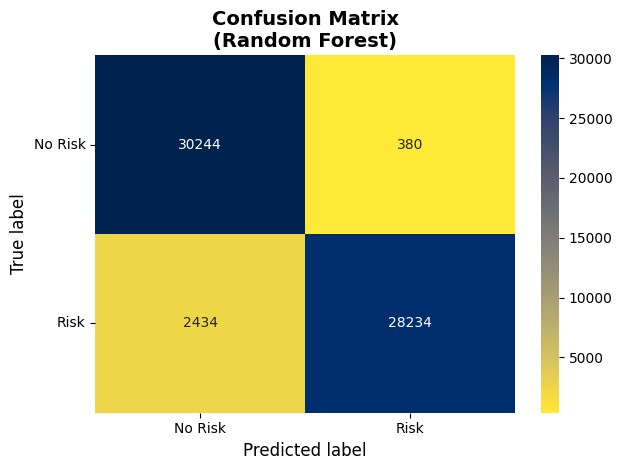

Random Forest ROC AUC: 0.95411


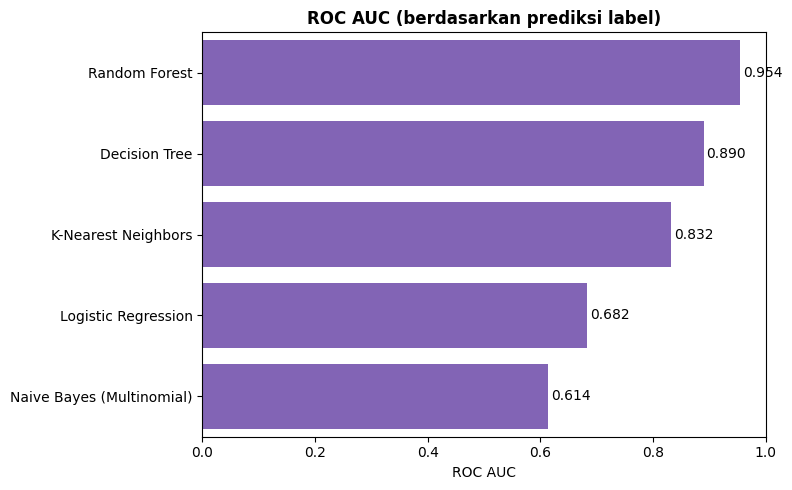

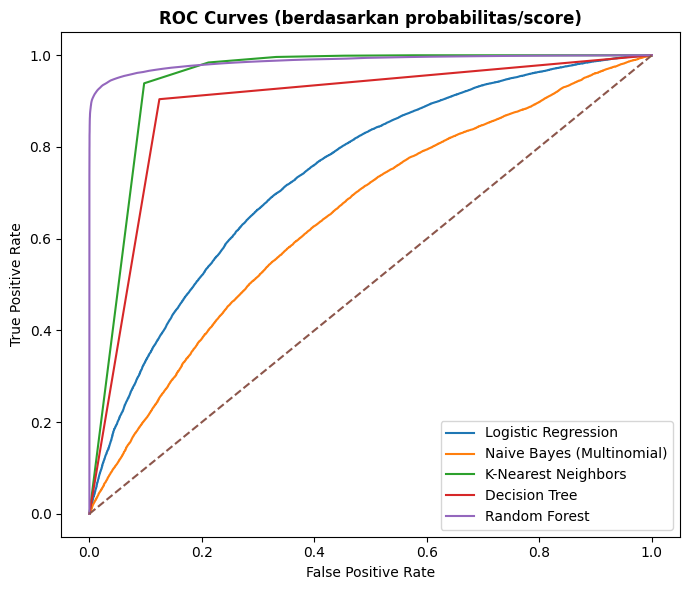

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# === util: plot confusion matrix (warna bisa diganti bebas, hasil metrik tdk berubah) ===
def plot_confmat(y_true, y_pred, title):
    cm = pd.DataFrame(confusion_matrix(y_true, y_pred),
                      index=['No Risk', 'Risk'], columns=['No Risk', 'Risk'])
    plt.figure()
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='cividis_r',
                     annot_kws={'size': 10})
    ax.yaxis.set_ticklabels(ax.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)
    ax.xaxis.set_ticklabels(ax.xaxis.get_ticklabels(), rotation=0, ha='center', fontsize=10)
    plt.title(title, fontsize=14, color='black', weight='bold')
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.tight_layout()
    plt.show()

# === util: dapatkan score untuk ROC curve jika ada (visualisasi saja) ===
def get_scores_for_roc(model, X):
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    if hasattr(model, "decision_function"):
        return model.decision_function(X)
    return None

# === daftar model (parameter sama seperti punyamu) ===
models = [
    ("Logistic Regression", LogisticRegression(max_iter=1000)),
    ("Naive Bayes (Multinomial)", MultinomialNB()),
    ("K-Nearest Neighbors", KNeighborsClassifier()),
    ("Decision Tree", DecisionTreeClassifier()),
    ("Random Forest", RandomForestClassifier()),
]

roc_auc_summary = []

# === train, evaluasi, dan plot CM (hasil metrik sama seperti kodenmu) ===
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n{name} - Classification Report")
    print(classification_report(y_test, y_pred))

    # Confusion matrix (visualisasi — sama seperti yang kamu buat)
    plot_confmat(y_test, y_pred, f'Confusion Matrix\n({name})')

    # ROC AUC (pakai label prediksi seperti kodenmu → hasil sama)
    auc = round(roc_auc_score(y_test, y_pred), 5)
    roc_auc_summary.append((name, auc))
    print(f'{name} ROC AUC:', auc)

# === Visualisasi 1: Bar chart perbandingan ROC AUC (dari nilai yang dicetak di atas) ===
auc_df = pd.DataFrame(roc_auc_summary, columns=['Model', 'ROC_AUC']).sort_values('ROC_AUC', ascending=False)
plt.figure(figsize=(8, 5))
sns.barplot(data=auc_df, x='ROC_AUC', y='Model', color='#7e57c2')
plt.title('ROC AUC (berdasarkan prediksi label)', weight='bold')
plt.xlabel('ROC AUC')
plt.ylabel('')
for i, (m, v) in enumerate(zip(auc_df['Model'], auc_df['ROC_AUC'])):
    plt.text(v + 0.005, i, f'{v:.3f}', va='center')
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

# === Visualisasi 2: ROC curve gabungan (hanya visual; tidak mengubah metrik di atas) ===
plt.figure(figsize=(7, 6))
plotted_any = False
for name, model in models:
    y_score = get_scores_for_roc(model, X_test)
    if y_score is None:
        continue
    fpr, tpr, _ = roc_curve(y_test, y_score)
    plt.plot(fpr, tpr, label=name)
    plotted_any = True

if plotted_any:
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.title('ROC Curves (berdasarkan probabilitas/score)', weight='bold')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Tidak ada model yang menyediakan skor probabilitas untuk ROC curve.")


Shape awal: (48744, 121)
Shape setelah drop: (48744, 92)
Kolom yang mengandung 'XNA' atau 'Unknown': ['ORGANIZATION_TYPE']
Jumlah duplikat: 0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Jumlah data: 39458 39458


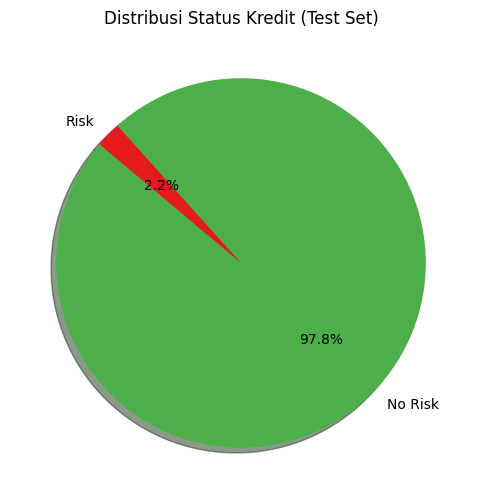

/tmp/ipython-input-959491081.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_counts.index, y=target_counts.values, palette=['#4daf4a', '#e41a1c'])


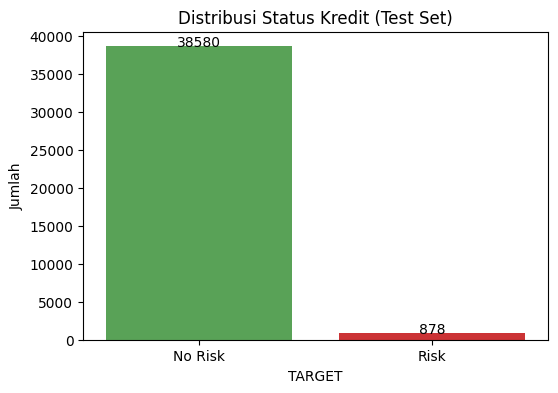

TARGET
0    38580
1      878
Name: count, dtype: int64


In [31]:
# === Load Data Test ===
df_test = pd.read_csv('/content/application_test.csv')
print("Shape awal:", df_test.shape)

# === Hapus kolom >50% missing ===
def drop_columns(df):
    missing_pct = (df.isnull().sum() / len(df)) * 100
    cols_to_drop = missing_pct[missing_pct > 50].index
    return df.drop(columns=cols_to_drop)

df_test = drop_columns(df_test)
print("Shape setelah drop:", df_test.shape)

# === Isi missing values ===
def input_missing_value(df):
    for col in df.columns[df.isnull().any()]:
        if df[col].dtype == 'object':
            df[col] = df[col].fillna(df[col].mode()[0])
        else:
            df[col] = df[col].fillna(df[col].median())
    return df

df_test = input_missing_value(df_test)

# === Cek kolom 'XNA' atau 'Unknown' ===
obj_cols = df_test.select_dtypes(include='object')
cols_xna_unknown = obj_cols.columns[obj_cols.isin(['XNA', 'Unknown']).any()]
print("Kolom yang mengandung 'XNA' atau 'Unknown':", list(cols_xna_unknown))

# === Drop ORGANIZATION_TYPE ===
df_test = df_test.drop(columns=['ORGANIZATION_TYPE'], errors='ignore')

# === Buang duplikat ===
print("Jumlah duplikat:", df_test.duplicated().sum())

# === Perbaiki nilai negatif ===
num_test = df_test.select_dtypes(exclude='object').copy()
neg_cols = num_test.columns[(num_test < 0).any()]
num_test[neg_cols] = -num_test[neg_cols]

# === Filter outlier ===
rules = [
    num_test['CNT_CHILDREN'] <= 5,
    num_test['CNT_FAM_MEMBERS'] <= 7,
    num_test['DAYS_EMPLOYED'] != -365243,
    num_test['AMT_ANNUITY'] != 258025.5,
    num_test['AMT_INCOME_TOTAL'] != 1.170000e+08,
    num_test['OBS_60_CNT_SOCIAL_CIRCLE'] != 344,
    num_test['DEF_30_CNT_SOCIAL_CIRCLE'] != 34,
    num_test['DEF_60_CNT_SOCIAL_CIRCLE'] != 24,
    num_test['AMT_REQ_CREDIT_BUREAU_QRT'] != 261
]
mask = np.logical_and.reduce(rules)
num_test = num_test[mask]

# === Sinkronkan index ke df_test asli ===
df_test = df_test.loc[num_test.index].copy()

# === Feature engineering AGE ===
df_test['AGE'] = np.floor(df_test['DAYS_BIRTH'] / -365).astype(int)
df_test.drop(columns='DAYS_BIRTH', inplace=True)

# === Pastikan kolom train & test sama ===
train_cols = set(df_copy[features].columns)
test_cols = set(df_test.columns)
missing_in_test = list(train_cols - test_cols)
df_test[missing_in_test] = 0
df_test = df_test[list(df_copy[features].columns)]

# === Encode object columns ===
cat_cols_test = df_test.select_dtypes(include='object').columns
df_test[cat_cols_test] = df_test[cat_cols_test].apply(LabelEncoder().fit_transform)

# === Scaling ===
df_test = pd.DataFrame(
    MinMaxScaler().fit_transform(df_test),
    columns=df_test.columns
)

from sklearn.ensemble import RandomForestClassifier

# Buat & latih ulang model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Prediksi
predictions = rf_model.predict(df_test)
df_test['TARGET'] = predictions
print("Jumlah data:", len(predictions), len(df_test))


# === Distribusi prediksi ===
target_counts = df_test['TARGET'].value_counts()

# Pie chart (warna baru)
plt.figure(figsize=(6, 6))
plt.pie(
    target_counts,
    labels=['No Risk', 'Risk'],
    autopct='%1.1f%%',
    colors=['#4daf4a', '#e41a1c'],  # hijau & merah
    startangle=140,
    shadow=True
)
plt.title('Distribusi Status Kredit (Test Set)')
plt.show()

# Bar chart tambahan
plt.figure(figsize=(6, 4))
sns.barplot(x=target_counts.index, y=target_counts.values, palette=['#4daf4a', '#e41a1c'])
plt.xticks([0, 1], ['No Risk', 'Risk'])
plt.ylabel('Jumlah')
plt.title('Distribusi Status Kredit (Test Set)')
for i, val in enumerate(target_counts.values):
    plt.text(i, val + 0.5, str(val), ha='center')
plt.show()

print(target_counts)


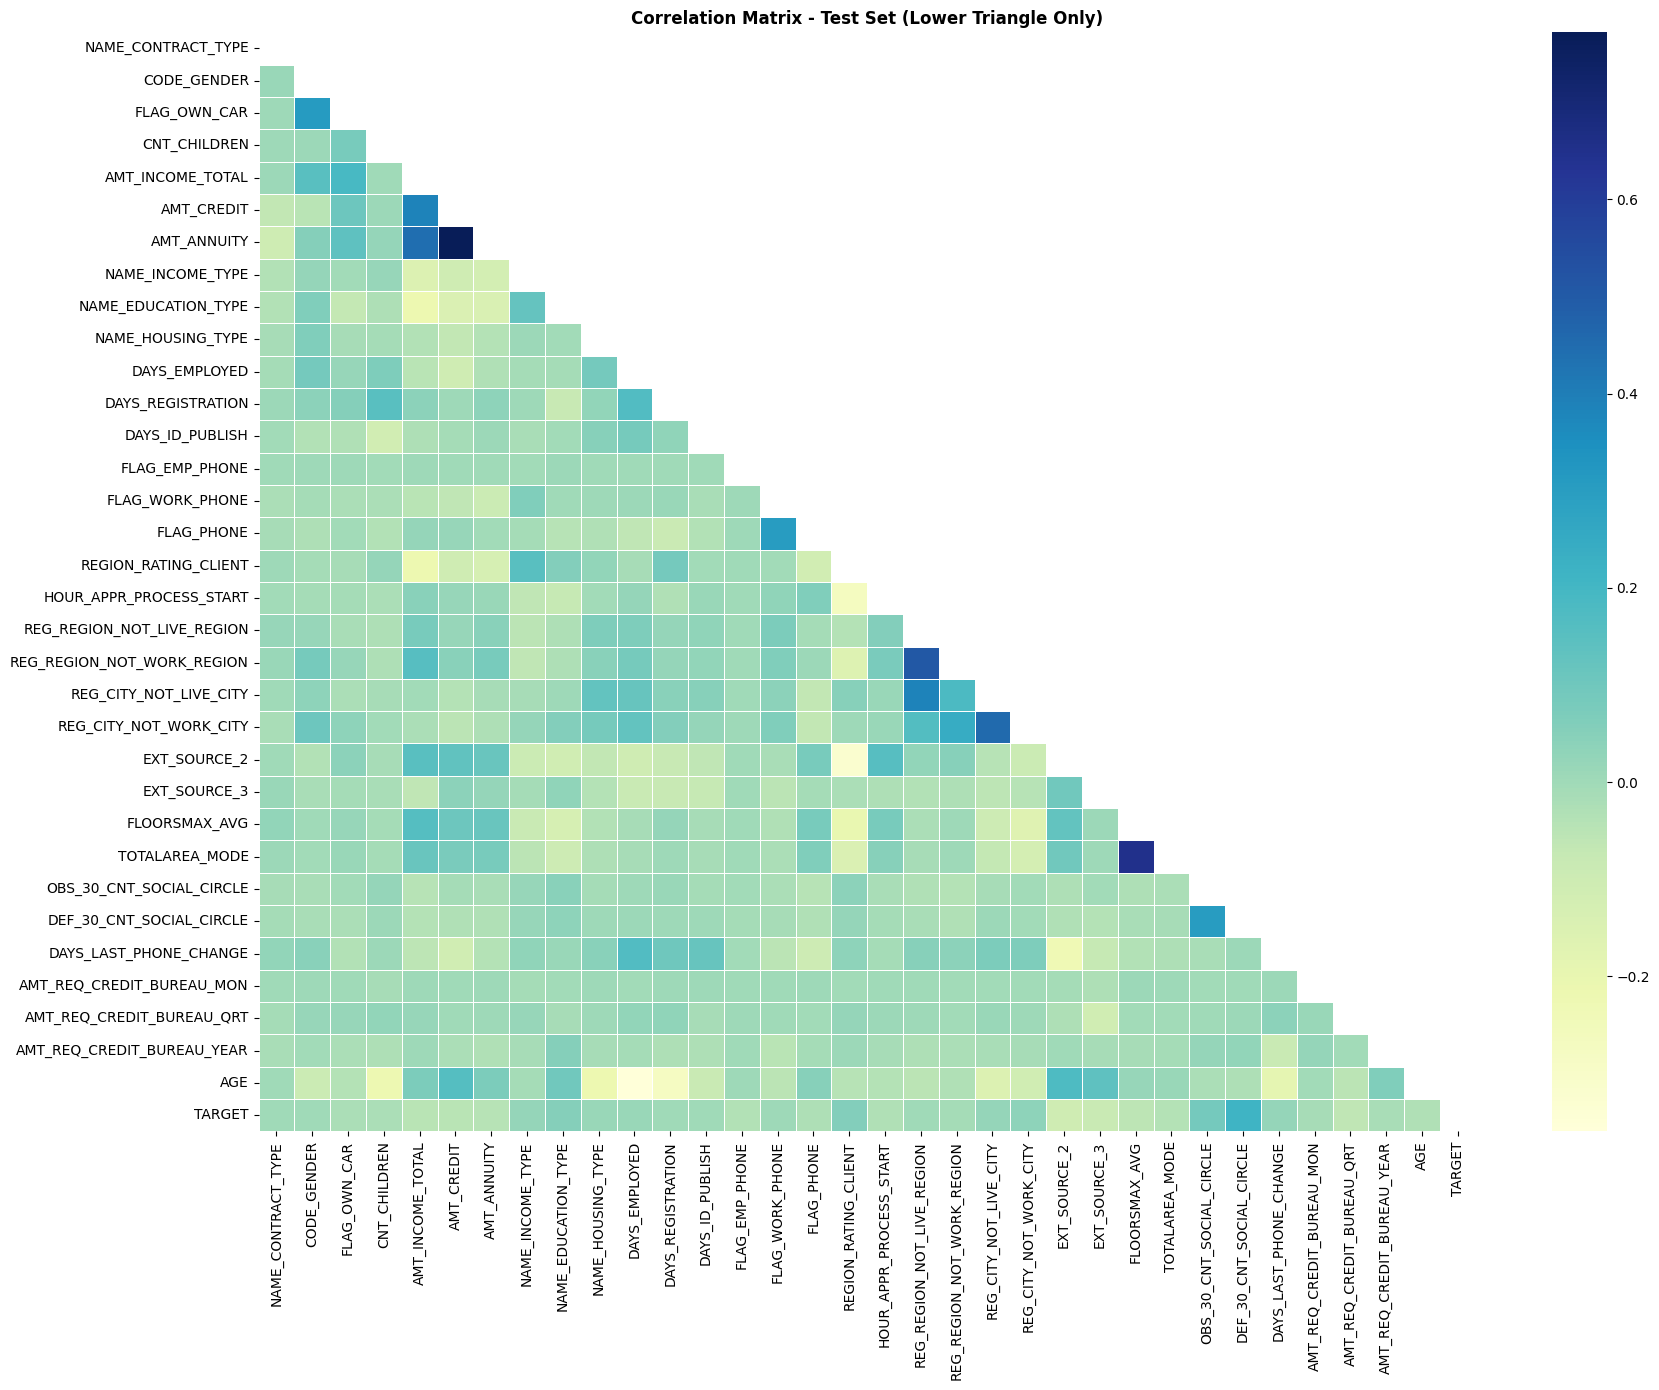

In [32]:
# === Heatmap korelasi (test set) ===
# Jika df_test sudah berupa DataFrame berskala (kolom = fitur numerik)
corr_test = df_test.corr(numeric_only=True)

# Mask segitiga atas
mask = np.triu(np.ones_like(corr_test, dtype=bool))

plt.figure(figsize=(18, 14))
sns.heatmap(
    corr_test,
    mask=mask,
    cmap='YlGnBu',      # warna beda dari 'coolwarm'
    annot=False,
    linewidths=0.4
)
plt.title('Correlation Matrix - Test Set (Lower Triangle Only)', weight='bold')
plt.tight_layout()
plt.show()
